# Итог:
Провел анализ полученного на прошлом этапе датасета. Выявил количественные и категориальные признаки. Провел первый этап выявления самых бесполезных признаков. Преобразовал временные признаки. Нашел закономерности и проблемы. Провел анализ пропущенных значений и сгенерировал признак, который четко делит датасет на дефолтные и недефолтные наблюдения. Заполнил пропущенные значения в датасете. Для понижения размерности сжал количественные признаки методом РСА. Подготовил датасет к предсказанию.

In [1]:
!pip install missingno

In [3]:
import numpy as np
import pandas as pd
import datetime
import time
import missingno as msno
from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def fixing_nan(df, cnt_nan = 40):
    """ Функция создает колонки выявляющие признаки, 
    в которых количество None больше чем cnt_nan"""
    for col in df.columns:
        if df[col].isna().sum():
            df[f"{col}_nan"] = 1
            df[f"{col}_nan"] = df[f"{col}_nan"] * df[col].isna()
            if len(df.loc[df[f"{col}_nan"] == 1]) < cnt_nan:
                df.drop(columns=[f"{col}_nan"], inplace=True)

In [5]:
def getDuplicateColumns(df):
 
    # Create an empty set
    duplicateColumnNames = set()
 
    # Iterate through all the columns
    # of dataframe
    for x in range(df.shape[1]):
 
        # Take column at xth index.
        col = df.iloc[:, x]
 
        # Iterate through all the columns in
        # DataFrame from (x + 1)th index to
        # last index
        for y in range(x + 1, df.shape[1]):
 
            # Take column at yth index.
            otherCol = df.iloc[:, y]
 
            # Check if two columns at x & y
            # index are equal or not,
            # if equal then adding
            # to the set
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
 
    # Return list of unique column names
    # whose contents are duplicates.
    return list(duplicateColumnNames)

In [6]:
def create_datetime_features(X, time_feature, year, month, day, copy = True):
    """ Создание datetime-признаков
    Parameters
    ___________
    X: pd.DataFrame - обучающая выборка
    copy: bool = True - булевый флаг использования копии выборки
    time_feature - временная фича
    year - год начальной даты
    month - месяц начальной даты
    day - день начальной даты
    """
    if copy:
        X = X.copy()
        
    base = pd.datetime(year, month, day)
    X[time_feature] = X[time_feature].apply(lambda x: datetime.timedelta(seconds = x))
    X[time_feature] = X[time_feature].apply(lambda x: base + x)
    
    X[f"{time_feature}_year"] = X[time_feature].dt.year
    X[f"{time_feature}_month"] = X[time_feature].dt.month
    X[f"{time_feature}_dow"] = X[time_feature].dt.dayofweek
    X[f"{time_feature}_day"] = X[time_feature].dt.day
    #X[f"{time_feature}_hour"] = X[time_feature].dt.hour
    
    return X

In [7]:
df = pd.read_csv("df_assembling.csv")
df.T

,0,1,2,3,4,5,6,7,8,9,...,561,562,563,564,565,566,567,568,569,570
Эмитент,2М,4К,А Девелопмент,А7 Агро,АБЗ-1,АВТОБАН-Финанс,АВТОДОМ,АК БАРС Банк,АО им. Т.Г. Шевченко,АПРИ Флай Плэнинг,...,ЮЛКМ,ЮРАШ-АЛТЫН,Ювелит,Юго-Западная ТЭЦ,ЮниМетрикс,ЮниСервис Капитал,ЯМАЛЫ-АЛТЫН,ЯТЭК,Ямал СПГ,реСтор
Дата начала размещения,2019-11-05,2021-09-02,2022-01-27,2019-08-15,2023-02-02,2021-09-14,2021-12-29,2020-12-24,2022-07-28,2022-11-08,...,2018-12-13,2009-07-23,2022-12-27,2014-07-31,2019-09-09,2021-03-04,2009-07-23,2021-04-12,2015-11-23,2021-06-17
Статус,В обращении,В обращении,В обращении,В обращении,В обращении,В обращении,В обращении,В обращении,В обращении,В обращении,...,В обращении,Дефолт,В обращении,В обращении,В обращении,В обращении,Дефолт,В обращении,В обращении,В обращении
"Состояние бумаги, eng.",Placed,Placed,Placed,Placed,Placed,Placed,Placed,Placed,Placed,Placed,...,Placed,NaN,Placed,NaN,Placed,Placed,NaN,Placed,Placed,Placed
Ломбардный список БР,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cnt_bonds,2,1,1,3,3,3,1,1,3,4,...,2,1,1,2,1,1,1,2,2,1
fininstId,22332,15422,14746,24502,32464,30825,28481,6291,22201,26405,...,24312,30962,8311,29319,22920,28608,30967,7574,30420,16406
inn,7806562022,6685187037,7814505170,5629020635,7804016807,7708813750,7714709349,1653001805,2358006710,7453326003,...,5407953687,1644055650,4400005628,7813323258,5405971433,5407068298,1644055434,1435032049,7709602713,7709678550
ogrn,1197847144703,1216600029140,1117847263940,1115658009246,1027802506742,1147746558596,1077759436336,1021600000124,1042332475085,1197456003360,...,1165476091098,1091644001877,1214400005225,1057811093746,1165476065039,1095407012469,1091644001646,1021401062187,1057746608754,1067746613065


In [8]:
"""Убрал из дефолтных организации, которые будут спасать регуляторы. Ну и пришлось убрать банки
и госучреждения, поскольку их в дефолтных не осталось. Обучать их не на чем."""

to_big_to_fail = ['Авангард АКБ', 'АК БАРС Банк','Альфа-Банк', 'Аэрофлот','ББР Банк','БКС Банк',
     'Балтика АКБ','Банк Аверс','Банк ВБРР','Банк ВТБ','Банк ГПБ','Банк ДОМ.РФ','Банк Зенит','Банк НационалСтандарт',
     'ВТБ СырьевТовары Фин','ВЭБ-лизинг','Вертолеты России','Внешпромбанк','Держава АКБ','Интерпромбанк КБ',
     'МРСК Урала','МСП БАНК','МТС-Банк','МеталлИнвестБанк','Курская Обл Адм','МеталлИнвестБанк',
    'МинУправлФинансСамарскОбл','Минфин Башкортостана','Минфин Калининград Обл','Минфин Камчатского края',
    'Минфин Карелии','Минфин Кировской Обл','Минфин Коми','Минфин КраснодарскогоКрая','Минфин Красноярского Края',
    'Минфин Кузбасса','Минфин Магаданск Обл','Минфин Марий Эл','Минфин НижегородскОбл','Минфин Новосибирской Обл',
    'Минфин Омской Обл','Минфин Оренбургской Обл','Минфин РФ','Минфин Саратовской Обл','Минфин Саха (Якутия)',
    'Минфин СвердлОбласти','Минфин СтавропольКрая','Минфин Тамбов Обл','Минфин Ульяновской Обл',
    'Минфин Хабаровского Края','Минфин Хакасии','Минфин Челябинской Обл','Московский Кредитный Банк',
    'Новосибирск Мэрия','Открытие Брокер','Открытие Холдинг','Промсвязьбанк','РМБ Банк','РН Банк',
    'РОСНАНО','РСГ-Финанс','РСХБ','Ренессанс Кредит КБ','РосДорБанк','Россети Кубань','Россети Центр',
    'Ростелеком','Росэксимбанк','СМП Банк','Сбербанк России','Совкомбанк','Солидарность КБ','ТГК-1',
    'ТКБ БАНК ПАО','Татфондбанк','Тинькофф Банк','Удмуртия Прав','УправлениеФинансЛипецкОбл','УралКапиталБанк',
    'ХКФ Банк','Экспобанк','Юго-Западная ТЭЦ']
print(len(to_big_to_fail))

# один боец умер, с первого взгляда не нашелся, искать некогда
print(len(set(df['Эмитент']) & set(to_big_to_fail)))

print(len(set(df['Эмитент']) - set(to_big_to_fail)))

not_big_to_fail= list(set(df['Эмитент']) - set(to_big_to_fail))

df = df[df['Эмитент'].isin(not_big_to_fail)]
df['target'].value_counts()

82
81
490


0    412
1     78
Name: target, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 0 to 570
Data columns (total 91 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Эмитент                              490 non-null    object 
 1   Дата начала размещения               490 non-null    object 
 2   Статус                               490 non-null    object 
 3   Состояние бумаги, eng.               436 non-null    object 
 4   Ломбардный список БР                 436 non-null    float64
 5   Isin                                 437 non-null    object 
 6   Код НРД                              436 non-null    object 
 7   Гос. рег. номер                      490 non-null    object 
 8   Номер гос. рег., НРД                 436 non-null    object 
 9   Наименование                         490 non-null    object 
 10  CFI                                  437 non-null    object 
 11  Страна заемщика                 

In [10]:
df['Эмитент'].nunique()

490

In [11]:
df['target'].value_counts(normalize=True)

0    0.840816
1    0.159184
Name: target, dtype: float64

Хоть сильный дисбаланс классов, но соотношение вполне рабочее. 

В связи с тем что колонки с рейтингами имеют повышенное количество пропусков, объединю эти признаки.

In [12]:
df['Рейтинг агрег. Эксперт РА'].fillna('NONE', inplace=True)
df['Рейтинг эмиссии Эксперт РА'].fillna('NONE', inplace=True)
df['Рейтинг агрег. АКРА'].fillna('NONE', inplace=True)
df['Рейтинг эмиссии АКРА'].fillna('NONE', inplace=True)

In [13]:
df['Рейтинг агрег'] = None

In [14]:
# if тупо сплюсовать эти колонки получается каша, можно еще попробовать отдать преимущество АКРА
df['Рейтинг агрег'] = df.apply(lambda x: x['Рейтинг агрег. Эксперт РА'] if\
        x['Рейтинг агрег. Эксперт РА'] != 'NONE' else x['Рейтинг агрег. АКРА'], axis=1)

In [15]:
df['Рейтинг эмиссии'] = df.apply(lambda x: x['Рейтинг эмиссии Эксперт РА'] if\
        x['Рейтинг эмиссии Эксперт РА'] != 'NONE' else x['Рейтинг эмиссии АКРА'], axis=1)

In [16]:
df.drop(columns=['Рейтинг агрег. Эксперт РА', 'Рейтинг агрег. АКРА', 
                'Рейтинг эмиссии Эксперт РА', 'Рейтинг эмиссии АКРА'], inplace=True)

In [17]:
#  Возвращаю обратно пропуски
df['Рейтинг агрег'] = df['Рейтинг агрег'].apply(lambda x: None if x=="NONE" else x)
df['Рейтинг эмиссии'] = df['Рейтинг эмиссии'].apply(lambda x: None if x=="NONE" else x)

In [18]:
df.reset_index(drop=True, inplace=True)

In [19]:
""" Функция создает колонки выявляющие признаки, в которых количество пропусков больше чем cnt_nan"""
fixing_nan(df, cnt_nan = 20)

In [20]:
df.columns[-50:]

Index(['Encumbrance', 'Рейтинг агрег', 'Рейтинг эмиссии',
       'Состояние бумаги, eng._nan', 'Ломбардный список БР_nan', 'Isin_nan',
       'Код НРД_nan', 'Номер гос. рег., НРД_nan', 'CFI_nan',
       'Сектор заемщика_nan', 'Сектор эмитента_nan', 'Эмитент: реестр МСП_nan',
       'Дюрация, лет_nan', 'Дюрация модиф., лет_nan', 'Дата ближ. оферты_nan',
       'Дата гос. рег-ции/присвоения_nan', 'Дата начала 1-го купона_nan',
       'Дата ближ. купона_nan', 'Дата ближ. объявления неизв. купона_nan',
       'Доходность эффект., %_nan', 'Доходность средневзв., %_nan',
       'НКД, в вал. ном._nan', 'Z-спред_nan', 'Цена, %_nan',
       'Дневной оборот на МБ_nan', 'Средний дневной оборот за мес._nan',
       'Объем торгов_nan', 'Объем торгов за 2 дня_nan',
       'Объем торгов за 5 дней_nan', 'Объем торгов за 10 дней_nan',
       'Объем торгов за месяц_nan', 'Кол-во сделок_nan',
       'Кол-во сделок за 2 дня_nan', 'Кол-во сделок за 5 дней_nan',
       'Кол-во сделок за 10 дней_nan', 'Кол-в

In [21]:
for col in ['Состояние бумаги, eng._nan', 'Ломбардный список БР_nan', 'Isin_nan',
       'Код НРД_nan', 'Номер гос. рег., НРД_nan', 'CFI_nan',
       'Сектор заемщика_nan', 'Сектор эмитента_nan', 'Эмитент: реестр МСП_nan',
       'Дюрация, лет_nan', 'Дюрация модиф., лет_nan', 'Дата ближ. оферты_nan',
       'Дата гос. рег-ции/присвоения_nan', 'Дата начала 1-го купона_nan',
       'Дата ближ. купона_nan', 'Дата ближ. объявления неизв. купона_nan',
       'Доходность эффект., %_nan', 'Доходность средневзв., %_nan',
       'НКД, в вал. ном._nan', 'Z-спред_nan', 'Цена, %_nan',
       'Дневной оборот на МБ_nan', 'Средний дневной оборот за мес._nan',
       'Объем торгов_nan', 'Объем торгов за 2 дня_nan',
       'Объем торгов за 5 дней_nan', 'Объем торгов за 10 дней_nan',
       'Объем торгов за месяц_nan', 'Кол-во сделок_nan',
       'Кол-во сделок за 2 дня_nan', 'Кол-во сделок за 5 дней_nan',
       'Кол-во сделок за 10 дней_nan', 'Кол-во сделок за месяц_nan',
       'Кол-во дней со сделками за 2 дня_nan',
       'Кол-во дней со сделками за 5 дней_nan',
       'Кол-во дней со сделками за 10 дней_nan',
       'Кол-во дней со сделками за месяц_nan', 'Кол-во купонов в год_nan',
       'Форма выпуска, eng_nan', 'Способ размещения_nan',
       'Тип по классиф. БР_nan', 'Вид залога_nan', 'Структурированность_nan',
       'Субординированность_nan', 'Класс эмитента по выручке_nan',
       'Рейтинг агрег_nan', 'Рейтинг эмиссии_nan']:
    print(col, f"Target distribution for not nan: {df.loc[df[col]==0]['target'].value_counts()}",\
             f"Target distribution for nan: {df.loc[df[col]==1]['target'].value_counts()}")
    print('**********************************************')

Состояние бумаги, eng._nan Target distribution for not nan: 0    391
1     45
Name: target, dtype: int64 Target distribution for nan: 1    33
0    21
Name: target, dtype: int64
**********************************************
Ломбардный список БР_nan Target distribution for not nan: 0    391
1     45
Name: target, dtype: int64 Target distribution for nan: 1    33
0    21
Name: target, dtype: int64
**********************************************
Isin_nan Target distribution for not nan: 0    391
1     46
Name: target, dtype: int64 Target distribution for nan: 1    32
0    21
Name: target, dtype: int64
**********************************************
Код НРД_nan Target distribution for not nan: 0    391
1     45
Name: target, dtype: int64 Target distribution for nan: 1    33
0    21
Name: target, dtype: int64
**********************************************
Номер гос. рег., НРД_nan Target distribution for not nan: 0    391
1     45
Name: target, dtype: int64 Target distribution for nan: 1    33

#  Признак "Дата начала 1-го купона_nan"  четко делит target на единицы и нули. Задача решена, всем спасибо, все свободны :-) Ладно, мы не ищем легких путей. Тогда не буду учитывать пропуски в признаках в помощь предсказанию. Хотя в них есть еще куча полезной информации.

In [22]:
df.drop(columns=['Состояние бумаги, eng._nan', 'Ломбардный список БР_nan', 'Isin_nan',
       'Код НРД_nan', 'Номер гос. рег., НРД_nan', 'CFI_nan',
       'Сектор заемщика_nan', 'Сектор эмитента_nan', 'Эмитент: реестр МСП_nan',
       'Дюрация, лет_nan', 'Дюрация модиф., лет_nan', 'Дата ближ. оферты_nan',
       'Дата гос. рег-ции/присвоения_nan', 'Дата начала 1-го купона_nan',
       'Дата ближ. купона_nan', 'Дата ближ. объявления неизв. купона_nan',
       'Доходность эффект., %_nan', 'Доходность средневзв., %_nan',
       'НКД, в вал. ном._nan', 'Z-спред_nan', 'Цена, %_nan',
       'Дневной оборот на МБ_nan', 'Средний дневной оборот за мес._nan',
       'Объем торгов_nan', 'Объем торгов за 2 дня_nan',
       'Объем торгов за 5 дней_nan', 'Объем торгов за 10 дней_nan',
       'Объем торгов за месяц_nan', 'Кол-во сделок_nan',
       'Кол-во сделок за 2 дня_nan', 'Кол-во сделок за 5 дней_nan',
       'Кол-во сделок за 10 дней_nan', 'Кол-во сделок за месяц_nan',
       'Кол-во дней со сделками за 2 дня_nan',
       'Кол-во дней со сделками за 5 дней_nan',
       'Кол-во дней со сделками за 10 дней_nan',
       'Кол-во дней со сделками за месяц_nan', 'Кол-во купонов в год_nan',
       'Форма выпуска, eng_nan', 'Способ размещения_nan',
       'Тип по классиф. БР_nan', 'Вид залога_nan', 'Структурированность_nan',
       'Субординированность_nan', 'Класс эмитента по выручке_nan',
       'Рейтинг агрег_nan', 'Рейтинг эмиссии_nan'
       ], inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 89 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Эмитент                              490 non-null    object 
 1   Дата начала размещения               490 non-null    object 
 2   Статус                               490 non-null    object 
 3   Состояние бумаги, eng.               436 non-null    object 
 4   Ломбардный список БР                 436 non-null    float64
 5   Isin                                 437 non-null    object 
 6   Код НРД                              436 non-null    object 
 7   Гос. рег. номер                      490 non-null    object 
 8   Номер гос. рег., НРД                 436 non-null    object 
 9   Наименование                         490 non-null    object 
 10  CFI                                  437 non-null    object 
 11  Страна заемщика                 

In [24]:
# Удаляю дубликаты колонок
dubl_cols = getDuplicateColumns(df)

In [25]:
for col in dubl_cols:
    print(col, df[col].value_counts())
    print("************************")

Страна эмитента RU    490
Name: Страна эмитента, dtype: int64
************************


In [26]:
# Удалил колонку-дубликат
df.drop(columns=dubl_cols, inplace=True)

In [27]:
df.drop_duplicates(ignore_index=True, inplace=True)

In [28]:
# удаляю неинформативные колонки
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

In [29]:
df.columns

Index(['Эмитент', 'Дата начала размещения', 'Статус', 'Состояние бумаги, eng.',
       'Ломбардный список БР', 'Isin', 'Код НРД', 'Гос. рег. номер',
       'Номер гос. рег., НРД', 'Наименование', 'CFI', 'Страна заемщика',
       'Сектор заемщика', 'Регион эмитента', 'Сектор эмитента',
       'Эмитент: реестр МСП', 'Страна риска', 'Дюрация, лет',
       'Дюрация модиф., лет', 'Дата ближ. возм. погаш.', 'Дата погашения',
       'Дата ближ. оферты', 'Дата окончания размещения', 'Дата регистрации',
       'Дата гос. рег-ции/присвоения', 'Срок обращения', 'Дата ближ. купона',
       'Дата ближ. объявления неизв. купона', 'Доходность эффект., %',
       'Доходность средневзв., %', 'НКД, в вал. ном.', 'Z-спред', 'Номинал',
       'Цена, %', 'Объем эмиссии, шт.', 'Заявл. объем эмиссии, в вал. ном.',
       'Объем в обращении, в вал. ном', 'Дневной оборот на МБ',
       'Средний дневной оборот за мес.', 'Объем торгов',
       'Объем торгов за 2 дня', 'Объем торгов за 5 дней',
       'Объем торг

# Преобразую даты

Исследую даты после преобразования из строк

In [30]:
df['Дата начала размещения'] = df['Дата начала размещения'].apply(lambda x: \
                                int(datetime.datetime.strptime(x, '%Y-%m-%d').strftime("%s")))

df1 = create_datetime_features(df, 'Дата начала размещения', 1970, 1, 1, copy = True)

df1.head()

/tmp/ipykernel_6800/3486164863.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  base = pd.datetime(year, month, day)


,Эмитент,Дата начала размещения,Статус,"Состояние бумаги, eng.",Ломбардный список БР,Isin,Код НРД,Гос. рег. номер,"Номер гос. рег., НРД",Наименование,...,fininstId,inn,ogrn,Encumbrance,Рейтинг агрег,Рейтинг эмиссии,Дата начала размещения_year,Дата начала размещения_month,Дата начала размещения_dow,Дата начала размещения_day
0,2М,2019-11-04 17:00:00,В обращении,Placed,0.0,RU000A100ZX3,RU000A100ZX3,4CDE-02-00503-R,4CDE-02-00503-R,2М-КО-02,...,22332,7806562022,1197847144703,1,None,None,2019,11,0,4
1,4К,2021-09-01 17:00:00,В обращении,Placed,0.0,RU000A103ML0,RU000A103ML0,4CDE-01-00041-L-001P,4CDE-01-00041-L-001P,4К-KO1,...,15422,6685187037,1216600029140,0,None,None,2021,9,2,1
2,А Девелопмент,2022-01-26 17:00:00,В обращении,Placed,0.0,RU000A104FX7,RU000A104FX7,4-01-00627-R,4-01-00627-R,А Девелопмент-01-об,...,14746,7814505170,1117847263940,0,None,None,2022,1,2,26
3,А7 Агро,2019-08-14 17:00:00,В обращении,Placed,0.0,RU000A100QH5,RU000A100QH5,4CDE-03-00411-R,4CDE-03-00411-R,А7 Агро-КО-03,...,24502,5629020635,1115658009246,1,None,None,2019,8,2,14
4,АБЗ-1,2023-02-01 17:00:00,В обращении,Placed,0.0,RU000A105SX7,RU000A105SX7,4B02-03-01671-D-001P,4B02-03-01671-D-001P,АБЗ-1-001Р-03-боб,...,32464,7804016807,1027802506742,1,BBB(RU),BBB(RU),2023,2,2,1


In [31]:
df1['Дата ближ. возм. погаш.'] = df1['Дата ближ. возм. погаш.'].apply(lambda x: \
                                int(datetime.datetime.strptime(x, '%Y-%m-%d').strftime("%s")))

df2 = create_datetime_features(df1, 'Дата ближ. возм. погаш.', 1970, 1, 1, copy = True)

df2.head()

/tmp/ipykernel_6800/3486164863.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  base = pd.datetime(year, month, day)


,Эмитент,Дата начала размещения,Статус,"Состояние бумаги, eng.",Ломбардный список БР,Isin,Код НРД,Гос. рег. номер,"Номер гос. рег., НРД",Наименование,...,Рейтинг агрег,Рейтинг эмиссии,Дата начала размещения_year,Дата начала размещения_month,Дата начала размещения_dow,Дата начала размещения_day,Дата ближ. возм. погаш._year,Дата ближ. возм. погаш._month,Дата ближ. возм. погаш._dow,Дата ближ. возм. погаш._day
0,2М,2019-11-04 17:00:00,В обращении,Placed,0.0,RU000A100ZX3,RU000A100ZX3,4CDE-02-00503-R,4CDE-02-00503-R,2М-КО-02,...,None,None,2019,11,0,4,2024,10,0,28
1,4К,2021-09-01 17:00:00,В обращении,Placed,0.0,RU000A103ML0,RU000A103ML0,4CDE-01-00041-L-001P,4CDE-01-00041-L-001P,4К-KO1,...,None,None,2021,9,2,1,2026,8,2,26
2,А Девелопмент,2022-01-26 17:00:00,В обращении,Placed,0.0,RU000A104FX7,RU000A104FX7,4-01-00627-R,4-01-00627-R,А Девелопмент-01-об,...,None,None,2022,1,2,26,2023,1,2,25
3,А7 Агро,2019-08-14 17:00:00,В обращении,Placed,0.0,RU000A100QH5,RU000A100QH5,4CDE-03-00411-R,4CDE-03-00411-R,А7 Агро-КО-03,...,None,None,2019,8,2,14,2023,12,5,16
4,АБЗ-1,2023-02-01 17:00:00,В обращении,Placed,0.0,RU000A105SX7,RU000A105SX7,4B02-03-01671-D-001P,4B02-03-01671-D-001P,АБЗ-1-001Р-03-боб,...,BBB(RU),BBB(RU),2023,2,2,1,2026,1,2,28


In [32]:
df2['Дата погашения'] = df2['Дата погашения'].apply(lambda x: \
                                int(datetime.datetime.strptime(x, '%Y-%m-%d').strftime("%s")))

df3 = create_datetime_features(df2, 'Дата погашения', 1970, 1, 1, copy = True)

df3.head()

/tmp/ipykernel_6800/3486164863.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  base = pd.datetime(year, month, day)


,Эмитент,Дата начала размещения,Статус,"Состояние бумаги, eng.",Ломбардный список БР,Isin,Код НРД,Гос. рег. номер,"Номер гос. рег., НРД",Наименование,...,Дата начала размещения_dow,Дата начала размещения_day,Дата ближ. возм. погаш._year,Дата ближ. возм. погаш._month,Дата ближ. возм. погаш._dow,Дата ближ. возм. погаш._day,Дата погашения_year,Дата погашения_month,Дата погашения_dow,Дата погашения_day
0,2М,2019-11-04 17:00:00,В обращении,Placed,0.0,RU000A100ZX3,RU000A100ZX3,4CDE-02-00503-R,4CDE-02-00503-R,2М-КО-02,...,0,4,2024,10,0,28,2024,10,0,28
1,4К,2021-09-01 17:00:00,В обращении,Placed,0.0,RU000A103ML0,RU000A103ML0,4CDE-01-00041-L-001P,4CDE-01-00041-L-001P,4К-KO1,...,2,1,2026,8,2,26,2026,8,2,26
2,А Девелопмент,2022-01-26 17:00:00,В обращении,Placed,0.0,RU000A104FX7,RU000A104FX7,4-01-00627-R,4-01-00627-R,А Девелопмент-01-об,...,2,26,2023,1,2,25,2025,1,2,22
3,А7 Агро,2019-08-14 17:00:00,В обращении,Placed,0.0,RU000A100QH5,RU000A100QH5,4CDE-03-00411-R,4CDE-03-00411-R,А7 Агро-КО-03,...,2,14,2023,12,5,16,2024,12,6,15
4,АБЗ-1,2023-02-01 17:00:00,В обращении,Placed,0.0,RU000A105SX7,RU000A105SX7,4B02-03-01671-D-001P,4B02-03-01671-D-001P,АБЗ-1-001Р-03-боб,...,2,1,2026,1,2,28,2026,1,2,28


In [33]:
# Заполняю пропуски модой
df3['Дата окончания размещения'].value_counts()

2009-07-23    30
2022-12-27     5
2009-09-21     5
2022-12-29     5
2022-12-07     4
              ..
2022-12-19     1
2020-01-31     1
2020-12-21     1
2019-09-16     1
2021-06-17     1
Name: Дата окончания размещения, Length: 373, dtype: int64

In [34]:
df3['Дата окончания размещения'].fillna('2009-07-23', inplace=True)

In [35]:
df3['Дата окончания размещения'] = df3['Дата окончания размещения'].apply(lambda x: \
                                int(datetime.datetime.strptime(x, '%Y-%m-%d').strftime("%s")))

df4 = create_datetime_features(df3, 'Дата окончания размещения', 1970, 1, 1, copy = True)

df4.head()

/tmp/ipykernel_6800/3486164863.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  base = pd.datetime(year, month, day)


,Эмитент,Дата начала размещения,Статус,"Состояние бумаги, eng.",Ломбардный список БР,Isin,Код НРД,Гос. рег. номер,"Номер гос. рег., НРД",Наименование,...,Дата ближ. возм. погаш._dow,Дата ближ. возм. погаш._day,Дата погашения_year,Дата погашения_month,Дата погашения_dow,Дата погашения_day,Дата окончания размещения_year,Дата окончания размещения_month,Дата окончания размещения_dow,Дата окончания размещения_day
0,2М,2019-11-04 17:00:00,В обращении,Placed,0.0,RU000A100ZX3,RU000A100ZX3,4CDE-02-00503-R,4CDE-02-00503-R,2М-КО-02,...,0,28,2024,10,0,28,2019,11,0,4
1,4К,2021-09-01 17:00:00,В обращении,Placed,0.0,RU000A103ML0,RU000A103ML0,4CDE-01-00041-L-001P,4CDE-01-00041-L-001P,4К-KO1,...,2,26,2026,8,2,26,2022,2,0,14
2,А Девелопмент,2022-01-26 17:00:00,В обращении,Placed,0.0,RU000A104FX7,RU000A104FX7,4-01-00627-R,4-01-00627-R,А Девелопмент-01-об,...,2,25,2025,1,2,22,2022,4,1,26
3,А7 Агро,2019-08-14 17:00:00,В обращении,Placed,0.0,RU000A100QH5,RU000A100QH5,4CDE-03-00411-R,4CDE-03-00411-R,А7 Агро-КО-03,...,5,16,2024,12,6,15,2019,8,2,14
4,АБЗ-1,2023-02-01 17:00:00,В обращении,Placed,0.0,RU000A105SX7,RU000A105SX7,4B02-03-01671-D-001P,4B02-03-01671-D-001P,АБЗ-1-001Р-03-боб,...,2,28,2026,1,2,28,2023,2,2,8


In [36]:
df['Дата регистрации'].value_counts()

2009-07-21    30
2009-09-03    17
2022-12-26     5
2022-12-08     4
2020-10-19     3
              ..
2019-08-02     1
2022-07-20     1
2017-12-08     1
2022-01-27     1
2021-06-11     1
Name: Дата регистрации, Length: 366, dtype: int64

In [37]:
df4['Дата регистрации'].fillna('2009-07-21', inplace=True)

In [38]:
df4['Дата регистрации'] = df4['Дата регистрации'].apply(lambda x: \
                                int(datetime.datetime.strptime(x, '%Y-%m-%d').strftime("%s")))

df5 = create_datetime_features(df4, 'Дата регистрации', 1970, 1, 1, copy = True)

df5.head()

/tmp/ipykernel_6800/3486164863.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  base = pd.datetime(year, month, day)


,Эмитент,Дата начала размещения,Статус,"Состояние бумаги, eng.",Ломбардный список БР,Isin,Код НРД,Гос. рег. номер,"Номер гос. рег., НРД",Наименование,...,Дата погашения_dow,Дата погашения_day,Дата окончания размещения_year,Дата окончания размещения_month,Дата окончания размещения_dow,Дата окончания размещения_day,Дата регистрации_year,Дата регистрации_month,Дата регистрации_dow,Дата регистрации_day
0,2М,2019-11-04 17:00:00,В обращении,Placed,0.0,RU000A100ZX3,RU000A100ZX3,4CDE-02-00503-R,4CDE-02-00503-R,2М-КО-02,...,0,28,2019,11,0,4,2019,10,2,23
1,4К,2021-09-01 17:00:00,В обращении,Placed,0.0,RU000A103ML0,RU000A103ML0,4CDE-01-00041-L-001P,4CDE-01-00041-L-001P,4К-KO1,...,2,26,2022,2,0,14,2021,8,3,26
2,А Девелопмент,2022-01-26 17:00:00,В обращении,Placed,0.0,RU000A104FX7,RU000A104FX7,4-01-00627-R,4-01-00627-R,А Девелопмент-01-об,...,2,22,2022,4,1,26,2021,10,3,21
3,А7 Агро,2019-08-14 17:00:00,В обращении,Placed,0.0,RU000A100QH5,RU000A100QH5,4CDE-03-00411-R,4CDE-03-00411-R,А7 Агро-КО-03,...,6,15,2019,8,2,14,2019,7,0,8
4,АБЗ-1,2023-02-01 17:00:00,В обращении,Placed,0.0,RU000A105SX7,RU000A105SX7,4B02-03-01671-D-001P,4B02-03-01671-D-001P,АБЗ-1-001Р-03-боб,...,2,28,2023,2,2,8,2022,9,1,20


In [39]:
df['Дата гос. рег-ции/присвоения'].value_counts()

2022-12-26    5
2022-12-08    4
2022-12-01    3
2022-12-27    3
2021-09-02    3
             ..
2022-07-20    1
2017-12-08    1
2022-01-27    1
2018-12-13    1
2021-06-11    1
Name: Дата гос. рег-ции/присвоения, Length: 360, dtype: int64

In [40]:
df5['Дата гос. рег-ции/присвоения'].fillna('2022-12-26', inplace=True)

In [41]:
df5['Дата гос. рег-ции/присвоения'] = df5['Дата гос. рег-ции/присвоения'].apply(lambda x: \
                                int(datetime.datetime.strptime(x, '%Y-%m-%d').strftime("%s")))

df6 = create_datetime_features(df5, 'Дата гос. рег-ции/присвоения', 1970, 1, 1, copy = True)

df6.head()

/tmp/ipykernel_6800/3486164863.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  base = pd.datetime(year, month, day)


,Эмитент,Дата начала размещения,Статус,"Состояние бумаги, eng.",Ломбардный список БР,Isin,Код НРД,Гос. рег. номер,"Номер гос. рег., НРД",Наименование,...,Дата окончания размещения_dow,Дата окончания размещения_day,Дата регистрации_year,Дата регистрации_month,Дата регистрации_dow,Дата регистрации_day,Дата гос. рег-ции/присвоения_year,Дата гос. рег-ции/присвоения_month,Дата гос. рег-ции/присвоения_dow,Дата гос. рег-ции/присвоения_day
0,2М,2019-11-04 17:00:00,В обращении,Placed,0.0,RU000A100ZX3,RU000A100ZX3,4CDE-02-00503-R,4CDE-02-00503-R,2М-КО-02,...,0,4,2019,10,2,23,2019,10,2,23
1,4К,2021-09-01 17:00:00,В обращении,Placed,0.0,RU000A103ML0,RU000A103ML0,4CDE-01-00041-L-001P,4CDE-01-00041-L-001P,4К-KO1,...,0,14,2021,8,3,26,2021,8,3,26
2,А Девелопмент,2022-01-26 17:00:00,В обращении,Placed,0.0,RU000A104FX7,RU000A104FX7,4-01-00627-R,4-01-00627-R,А Девелопмент-01-об,...,1,26,2021,10,3,21,2021,10,3,21
3,А7 Агро,2019-08-14 17:00:00,В обращении,Placed,0.0,RU000A100QH5,RU000A100QH5,4CDE-03-00411-R,4CDE-03-00411-R,А7 Агро-КО-03,...,2,14,2019,7,0,8,2019,7,0,8
4,АБЗ-1,2023-02-01 17:00:00,В обращении,Placed,0.0,RU000A105SX7,RU000A105SX7,4B02-03-01671-D-001P,4B02-03-01671-D-001P,АБЗ-1-001Р-03-боб,...,2,8,2022,9,1,20,2022,9,1,20


In [42]:
df['Дата ближ. купона'].value_counts()

2023-03-20    15
2023-03-13    14
2023-03-27    14
2023-03-23    11
2023-06-06    11
              ..
2023-06-27     1
2023-08-15     1
2026-02-05     1
2032-11-15     1
2023-09-29     1
Name: Дата ближ. купона, Length: 129, dtype: int64

In [43]:
df6['Дата ближ. купона'].fillna('2023-03-20', inplace=True)

In [44]:
df6['Дата ближ. купона'] = df6['Дата ближ. купона'].apply(lambda x: \
                                int(datetime.datetime.strptime(x, '%Y-%m-%d').strftime("%s")))

df7 = create_datetime_features(df6, 'Дата ближ. купона', 1970, 1, 1, copy = True)

df7.head()

/tmp/ipykernel_6800/3486164863.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  base = pd.datetime(year, month, day)


,Эмитент,Дата начала размещения,Статус,"Состояние бумаги, eng.",Ломбардный список БР,Isin,Код НРД,Гос. рег. номер,"Номер гос. рег., НРД",Наименование,...,Дата регистрации_dow,Дата регистрации_day,Дата гос. рег-ции/присвоения_year,Дата гос. рег-ции/присвоения_month,Дата гос. рег-ции/присвоения_dow,Дата гос. рег-ции/присвоения_day,Дата ближ. купона_year,Дата ближ. купона_month,Дата ближ. купона_dow,Дата ближ. купона_day
0,2М,2019-11-04 17:00:00,В обращении,Placed,0.0,RU000A100ZX3,RU000A100ZX3,4CDE-02-00503-R,4CDE-02-00503-R,2М-КО-02,...,2,23,2019,10,2,23,2023,5,0,1
1,4К,2021-09-01 17:00:00,В обращении,Placed,0.0,RU000A103ML0,RU000A103ML0,4CDE-01-00041-L-001P,4CDE-01-00041-L-001P,4К-KO1,...,3,26,2021,8,3,26,2023,8,2,30
2,А Девелопмент,2022-01-26 17:00:00,В обращении,Placed,0.0,RU000A104FX7,RU000A104FX7,4-01-00627-R,4-01-00627-R,А Девелопмент-01-об,...,3,21,2021,10,3,21,2023,4,2,26
3,А7 Агро,2019-08-14 17:00:00,В обращении,Placed,0.0,RU000A100QH5,RU000A100QH5,4CDE-03-00411-R,4CDE-03-00411-R,А7 Агро-КО-03,...,0,8,2019,7,0,8,2023,12,6,17
4,АБЗ-1,2023-02-01 17:00:00,В обращении,Placed,0.0,RU000A105SX7,RU000A105SX7,4B02-03-01671-D-001P,4B02-03-01671-D-001P,АБЗ-1-001Р-03-боб,...,1,20,2022,9,1,20,2023,5,2,3


In [45]:
# слишком много пропусков
df['Дата ближ. объявления неизв. купона'].isna().sum()

476

In [46]:
del df, df2, df3, df4, df5, df6

In [47]:
df7.drop(columns=['Дата ближ. возм. погаш.', 'Дата погашения',
       'Дата ближ. оферты', 'Дата окончания размещения', 'Дата регистрации',
       'Дата гос. рег-ции/присвоения', 'Дата ближ. купона',
       'Дата ближ. объявления неизв. купона'], inplace=True)

# Анализ целевой переменной

Mean-target: 0.1592


/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Index')

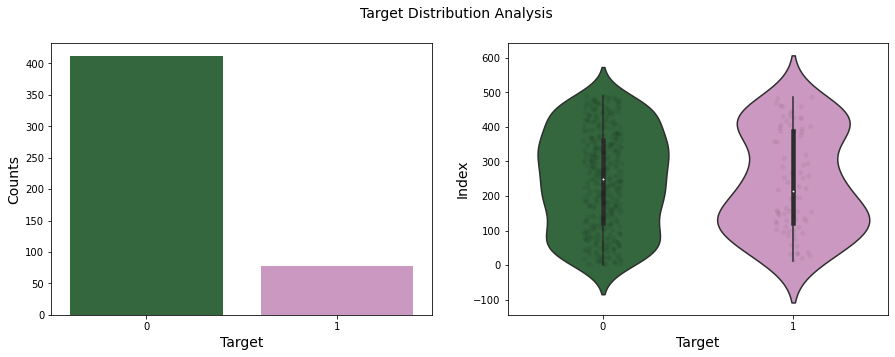

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Target Distribution Analysis", size=14)
print(f"Mean-target: {round(df7.target.mean(), 4)}")

sns.countplot(df7.target, ax=axes[0], palette="cubehelix")
sns.violinplot(df7.target, df7.index, ax=axes[1], palette="cubehelix")
sns.stripplot(df7.target, df7.index, jitter=True, ax=axes[1], color="black", alpha=0.05)

axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Counts", fontsize=14)
axes[1].set_xlabel("Target", fontsize=14)
axes[1].set_ylabel("Index", fontsize=14)

Большой дисбаланс классов. Распределения на дефолтных и недефолтных данных разное.

# Исследование количественных признаков (упрощенное)

В виду малого количества наблюдений с исследуемым событием, большое количество признаков приведет к "проклятию размерности". Принял решение сделать понижение размерности методом  PCA всех количественных признаков до трех признаков. А для этого развернутый анализ не требуется, PCA самостоятельно выудит всю полезную информацию из признаков. После уменьшения количества категориальных признаков уже можно будет развернуть количественные обратно и провести исследование.

In [49]:
numerical_features = df7.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 69


Index(['Ломбардный список БР', 'Дюрация, лет', 'Дюрация модиф., лет',
       'Доходность эффект., %', 'Доходность средневзв., %', 'НКД, в вал. ном.',
       'Z-спред', 'Номинал', 'Цена, %', 'Объем эмиссии, шт.',
       'Заявл. объем эмиссии, в вал. ном.', 'Объем в обращении, в вал. ном',
       'Дневной оборот на МБ', 'Средний дневной оборот за мес.',
       'Объем торгов', 'Объем торгов за 2 дня', 'Объем торгов за 5 дней',
       'Объем торгов за 10 дней', 'Объем торгов за месяц', 'Кол-во сделок',
       'Кол-во сделок за 2 дня', 'Кол-во сделок за 5 дней',
       'Кол-во сделок за 10 дней', 'Кол-во сделок за месяц',
       'Кол-во дней со сделками за 2 дня', 'Кол-во дней со сделками за 5 дней',
       'Кол-во дней со сделками за 10 дней',
       'Кол-во дней со сделками за месяц', 'Ставка купона, %',
       'Кол-во купонов в год', 'Субординированность', 'Амортизируемость',
       'Конвертация', 'Закрытая подписка', 'target', 'not_isin', 'cnt_bonds',
       'fininstId', 'inn', 'ogrn', 

In [50]:
# Нахожу категориальные признаки среди количественных
spy_list = list(numerical_features.nunique().loc[numerical_features.nunique()< 12].index)
spy_list

['Ломбардный список БР',
 'Кол-во дней со сделками за 2 дня',
 'Кол-во дней со сделками за 5 дней',
 'Кол-во дней со сделками за 10 дней',
 'Кол-во купонов в год',
 'Субординированность',
 'Амортизируемость',
 'Конвертация',
 'Закрытая подписка',
 'target',
 'not_isin',
 'Encumbrance',
 'Дата начала размещения_dow',
 'Дата ближ. возм. погаш._dow',
 'Дата погашения_dow',
 'Дата окончания размещения_dow',
 'Дата регистрации_dow',
 'Дата гос. рег-ции/присвоения_dow',
 'Дата ближ. купона_year',
 'Дата ближ. купона_dow']

In [51]:
spy_list.extend([
       'Дата начала размещения_day', 'Дата ближ. возм. погаш._year',
       'Дата ближ. возм. погаш._day', 'Дата погашения_year', 'Дата погашения_day', 'Дата окончания размещения_day',
        'Дата регистрации_day','Дата гос. рег-ции/присвоения_day', 'Дата ближ. купона_day'])
spy_list

['Ломбардный список БР',
 'Кол-во дней со сделками за 2 дня',
 'Кол-во дней со сделками за 5 дней',
 'Кол-во дней со сделками за 10 дней',
 'Кол-во купонов в год',
 'Субординированность',
 'Амортизируемость',
 'Конвертация',
 'Закрытая подписка',
 'target',
 'not_isin',
 'Encumbrance',
 'Дата начала размещения_dow',
 'Дата ближ. возм. погаш._dow',
 'Дата погашения_dow',
 'Дата окончания размещения_dow',
 'Дата регистрации_dow',
 'Дата гос. рег-ции/присвоения_dow',
 'Дата ближ. купона_year',
 'Дата ближ. купона_dow',
 'Дата начала размещения_day',
 'Дата ближ. возм. погаш._year',
 'Дата ближ. возм. погаш._day',
 'Дата погашения_year',
 'Дата погашения_day',
 'Дата окончания размещения_day',
 'Дата регистрации_day',
 'Дата гос. рег-ции/присвоения_day',
 'Дата ближ. купона_day']

In [52]:
len(spy_list)

29

In [53]:
set(numerical_features.columns) - set(spy_list)

{'Z-спред',
 'cnt_bonds',
 'fininstId',
 'inn',
 'ogrn',
 'Дата ближ. возм. погаш._month',
 'Дата ближ. купона_month',
 'Дата гос. рег-ции/присвоения_month',
 'Дата гос. рег-ции/присвоения_year',
 'Дата начала размещения_month',
 'Дата начала размещения_year',
 'Дата окончания размещения_month',
 'Дата окончания размещения_year',
 'Дата погашения_month',
 'Дата регистрации_month',
 'Дата регистрации_year',
 'Дневной оборот на МБ',
 'Доходность средневзв., %',
 'Доходность эффект., %',
 'Дюрация модиф., лет',
 'Дюрация, лет',
 'Заявл. объем эмиссии, в вал. ном.',
 'Кол-во дней со сделками за месяц',
 'Кол-во сделок',
 'Кол-во сделок за 10 дней',
 'Кол-во сделок за 2 дня',
 'Кол-во сделок за 5 дней',
 'Кол-во сделок за месяц',
 'НКД, в вал. ном.',
 'Номинал',
 'Объем в обращении, в вал. ном',
 'Объем торгов',
 'Объем торгов за 10 дней',
 'Объем торгов за 2 дня',
 'Объем торгов за 5 дней',
 'Объем торгов за месяц',
 'Объем эмиссии, шт.',
 'Средний дневной оборот за мес.',
 'Ставка купона,

In [54]:
# Все даты однозначно относятся к категориальным признакам
spy_list.extend(['Дата ближ. возм. погаш._month',
 'Дата ближ. купона_month',
 'Дата гос. рег-ции/присвоения_month',
 'Дата гос. рег-ции/присвоения_year',
 'Дата начала размещения_month',
 'Дата начала размещения_year',
 'Дата окончания размещения_month',
 'Дата окончания размещения_year',
 'Дата погашения_month',
 'Дата регистрации_month',
 'Дата регистрации_year'])

In [55]:
list(set(numerical_features.columns) - set(spy_list))

['Дюрация, лет',
 'Заявл. объем эмиссии, в вал. ном.',
 'Цена, %',
 'Кол-во сделок за 2 дня',
 'fininstId',
 'Объем торгов за 5 дней',
 'Кол-во сделок за 5 дней',
 'Кол-во сделок за 10 дней',
 'ogrn',
 'Средний дневной оборот за мес.',
 'Ставка купона, %',
 'Кол-во сделок за месяц',
 'Кол-во дней со сделками за месяц',
 'Номинал',
 'Объем торгов за 2 дня',
 'Объем торгов',
 'Дневной оборот на МБ',
 'Объем торгов за месяц',
 'Кол-во сделок',
 'Доходность эффект., %',
 'Объем эмиссии, шт.',
 'cnt_bonds',
 'Дюрация модиф., лет',
 'Объем торгов за 10 дней',
 'НКД, в вал. ном.',
 'Z-спред',
 'inn',
 'Объем в обращении, в вал. ном',
 'Доходность средневзв., %']

In [56]:
# Убиракю из обучения все коды
numerical_for_fit = ['Номинал', 'Кол-во сделок за 2 дня', 'Объем торгов за 2 дня', 'Цена, %',
 'НКД, в вал. ном.', 'Кол-во сделок за 10 дней', 'cnt_bonds', 'Дневной оборот на МБ', 'Кол-во дней со сделками за месяц',
 'Дюрация модиф., лет', 'Кол-во сделок за месяц', 'Доходность эффект., %', 'Объем торгов за 5 дней',
 'Кол-во сделок', 'Объем торгов за 10 дней', 'Объем торгов за месяц', 'Средний дневной оборот за мес.',
 'Ставка купона, %', 'Кол-во сделок за 5 дней', 'Z-спред', 'Дюрация, лет', 'Доходность средневзв., %',
 'Заявл. объем эмиссии, в вал. ном.', 'Объем эмиссии, шт.', 'Объем торгов', 'Объем в обращении, в вал. ном',
 ]

In [57]:
df_numerical = numerical_features[numerical_for_fit]
df_numerical.head()

,Номинал,Кол-во сделок за 2 дня,Объем торгов за 2 дня,"Цена, %","НКД, в вал. ном.",Кол-во сделок за 10 дней,cnt_bonds,Дневной оборот на МБ,Кол-во дней со сделками за месяц,"Дюрация модиф., лет",...,Средний дневной оборот за мес.,"Ставка купона, %",Кол-во сделок за 5 дней,Z-спред,"Дюрация, лет","Доходность средневзв., %","Заявл. объем эмиссии, в вал. ном.","Объем эмиссии, шт.",Объем торгов,"Объем в обращении, в вал. ном"
0,100000.0,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,...,NaN,14.00,NaN,NaN,NaN,NaN,1.950000e+08,1950,NaN,1.950000e+08
1,1000.0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,8.50,NaN,NaN,NaN,NaN,2.500000e+07,25000,NaN,2.500000e+07
2,1000.0,79.0,558789.2,98.43,15.18,287.0,1,253602.0,19.0,1.4403,...,412787.0,13.85,173.0,0.0,1.6658,15.7444,7.000000e+08,700000,253602.3,3.001450e+08
3,1000.0,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,...,NaN,7.00,NaN,0.0,NaN,NaN,1.000000e+08,100000,NaN,1.000000e+08
4,1000.0,497.0,9676818.7,101.35,12.88,3389.0,3,5122671.0,19.0,1.7146,...,11470880.0,14.25,1471.0,0.0,1.9589,14.3221,1.500000e+09,1500000,5122671.0,1.500000e+09


In [58]:
df_numerical.describe().T

,count,mean,std,min,25%,50%,75%,max
Номинал,490.0,6.386991e+05,9.709639e+06,1.0000,1.000000e+03,1.000000e+03,1.000000e+03,1.902000e+08
Кол-во сделок за 2 дня,306.0,1.564085e+02,3.020809e+02,0.0000,3.000000e+00,6.350000e+01,1.875000e+02,2.781000e+03
Объем торгов за 2 дня,306.0,6.542237e+06,3.152375e+07,0.0000,6.916450e+03,7.373867e+05,2.965249e+06,4.718941e+08
"Цена, %",254.0,9.559351e+01,1.782850e+01,3.1000,9.734500e+01,9.983500e+01,1.012350e+02,1.156200e+02
"НКД, в вал. ном.",252.0,4.739253e+01,2.394465e+02,0.0000,5.737500e+00,1.292000e+01,2.491750e+01,2.416440e+03
Кол-во сделок за 10 дней,306.0,7.334216e+02,1.327927e+03,0.0000,1.950000e+01,2.935000e+02,8.330000e+02,1.122700e+04
cnt_bonds,490.0,2.416327e+00,3.966390e+00,1.0000,1.000000e+00,1.000000e+00,3.000000e+00,6.100000e+01
Дневной оборот на МБ,248.0,5.142249e+06,3.306459e+07,85.0000,1.004188e+05,4.980170e+05,1.563704e+06,4.717593e+08
Кол-во дней со сделками за месяц,306.0,1.408170e+01,7.817374e+00,0.0000,9.250000e+00,1.900000e+01,1.900000e+01,1.900000e+01
"Дюрация модиф., лет",252.0,1.484598e+00,1.343950e+00,0.0000,7.870250e-01,1.276900e+00,1.871025e+00,1.295280e+01


In [59]:
def plot_stat_distribution(train):
    """
    Визуализация признака для обучающих данных;

    Parameters
    ----------
    train: pandas.core.frame.Series
        Значение признака на обучении.

    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    train.plot(ax=axes[0], color="#33137d")
    plt.suptitle(f"Feature name - {train.name}")
    axes[0].set_title("Train Distribution")
    plt.legend()

def plot_row_distribution(func: callable, train, axis = 1):
    """
    Визуализация распределения статистики по строке обучающих данных.

    Parameters
    ----------
    func: callable
        Функция для вычисления статистики.

    train: pandas.core.frame.Series
        Значение признака на обучении.

    axis: int, optional, default = 1
        Направление оси вдоль которой выполнять агрегацию данных.
        Значения могут быть: {0 or 'index', 1 or 'columns'}
        Опциональный параметр, по умолчанию, равен 1.

    """
    plt.figure(figsize=(15, 5))
    train = train.drop(["target"], axis=1).copy()
    train_stats = train.apply(func, axis=axis)

    plt.title(f"Distribution of {func} values per row in the train set")
    sns.distplot(train_stats, color="#007539", kde=True, bins=120, label='test')
    plt.xlabel(f"feature-{func}", size=13)
    plt.legend()
    plt.show()

# Стандартизация данных

Чтобы визуализировать статистики требуется привести данные к близкому диапазону. Использую Robuscaler чтобы нивелировать действие выбросов. В задачах классификации в мощных алгоритмах выбросы имеют низкое значение, и необходимо, чтобы алгоритм на них тоже обучился. Многие мощные алгоритмы не умеют экстраполировать данные, и чтобы он мог предсказывать на выбросах, необходимо его на  выбросах обучить.

In [60]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(df_numerical)
df_numerical_scal = pd.DataFrame(transformer.transform(df_numerical), columns=[df_numerical.columns])
df_numerical_scal.T

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
Номинал,99000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-900.000000,-999.000000,0.000000,0.000000,9000.000000,-999.000000,0.000000,0.000000,0.000000
Кол-во сделок за 2 дня,NaN,NaN,0.084011,NaN,2.349593,-0.094851,0.848238,0.322493,2.197832,-0.344173,...,0.235772,NaN,NaN,1.184282,0.013550,-0.327913,NaN,1.314363,NaN,2.029810
Объем торгов за 2 дня,NaN,NaN,-0.060371,NaN,3.021781,-0.103365,0.678932,0.008049,0.757398,-0.249258,...,-0.136496,NaN,NaN,1.498654,0.004240,-0.238910,NaN,1.234452,NaN,1.325503
"Цена, %",NaN,NaN,-0.361183,NaN,0.389460,-0.188946,-0.471722,0.679949,1.327763,-0.008997,...,1.813625,NaN,NaN,0.363753,-0.183805,-10.232648,NaN,-0.381748,NaN,-1.877892
"НКД, в вал. ном.",NaN,NaN,0.117831,NaN,-0.002086,1.551095,0.533889,0.297706,0.286236,-0.611575,...,5.260579,NaN,NaN,0.666319,-0.352450,0.960375,NaN,1.260688,NaN,0.275287
Кол-во сделок за 10 дней,NaN,NaN,-0.007990,NaN,3.805163,-0.219422,0.917640,0.527966,2.476337,-0.357099,...,-0.162876,NaN,NaN,1.501537,0.009219,-0.352182,NaN,1.331899,NaN,2.464044
cnt_bonds,0.500000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.500000,0.000000,...,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000
Дневной оборот на МБ,NaN,NaN,-0.167032,NaN,3.160460,-0.174289,0.892657,-0.120583,0.664576,-0.338363,...,-0.339611,NaN,NaN,0.610890,-0.004726,-0.332137,NaN,0.700861,NaN,2.051133
Кол-во дней со сделками за месяц,NaN,NaN,0.000000,NaN,0.000000,-0.102564,0.000000,0.000000,0.000000,-1.846154,...,0.000000,NaN,NaN,0.000000,0.000000,-1.230769,NaN,0.000000,NaN,0.000000
"Дюрация модиф., лет",NaN,NaN,0.150738,NaN,0.403782,-0.765867,0.121033,-0.683579,-0.680904,-0.495756,...,0.366790,NaN,NaN,0.712731,-1.151568,0.256365,NaN,-0.044926,NaN,-0.223616


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


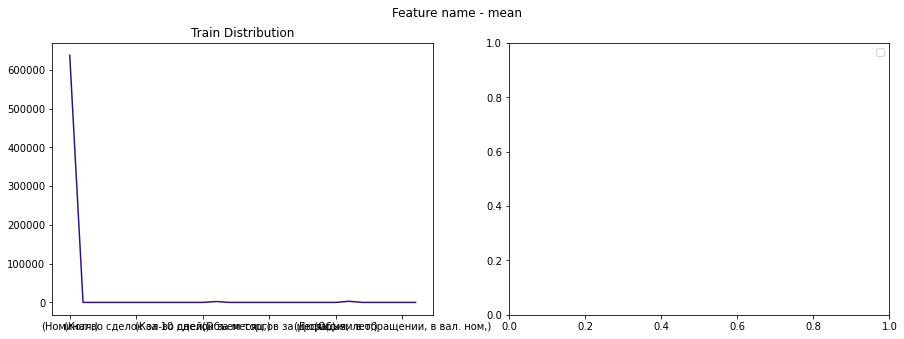

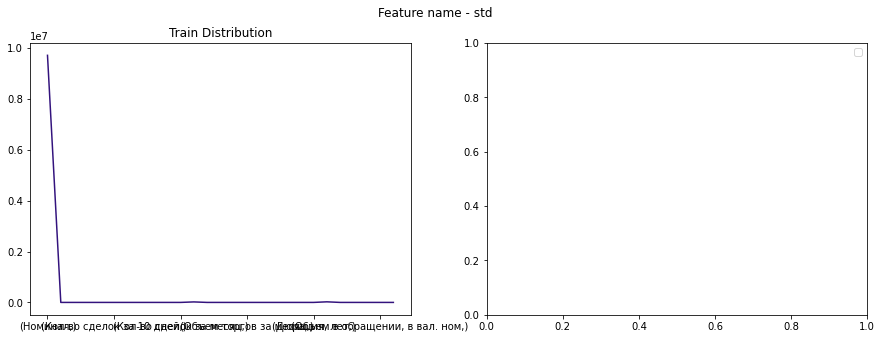

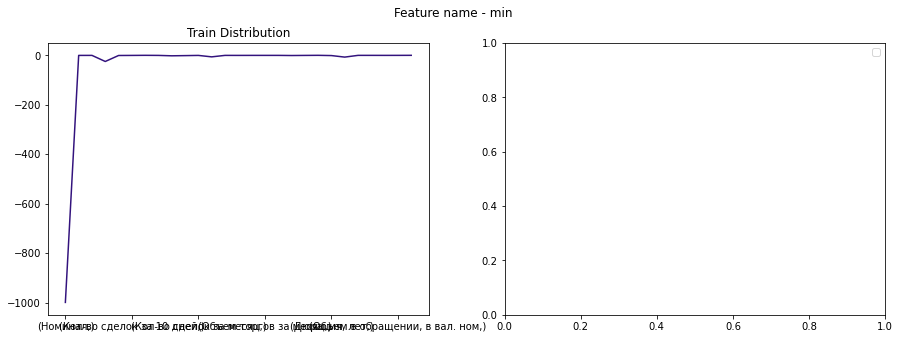

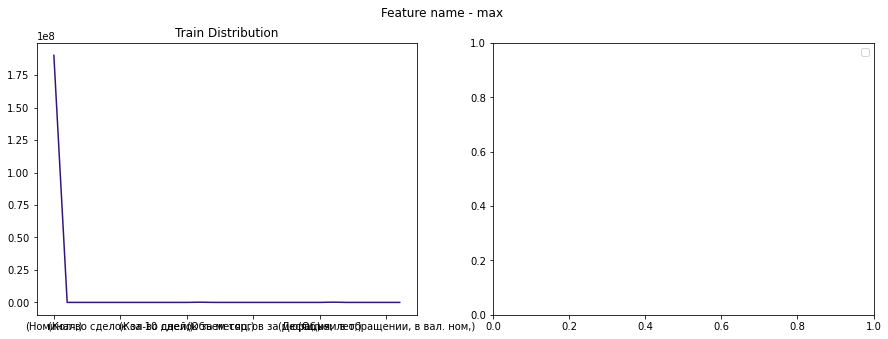

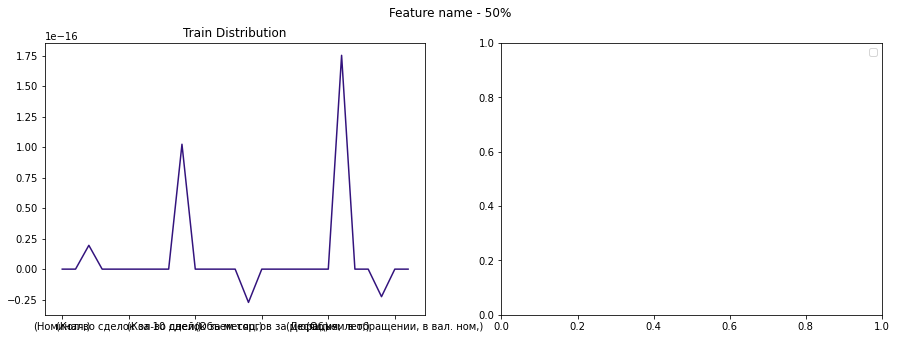

In [61]:
train_stats = pd.concat([df_numerical_scal, df7['target']], axis=1).describe()
for feature in ["mean", "std", "min", "max", "50%"]:
    plot_stat_distribution(train_stats.loc[feature])

/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


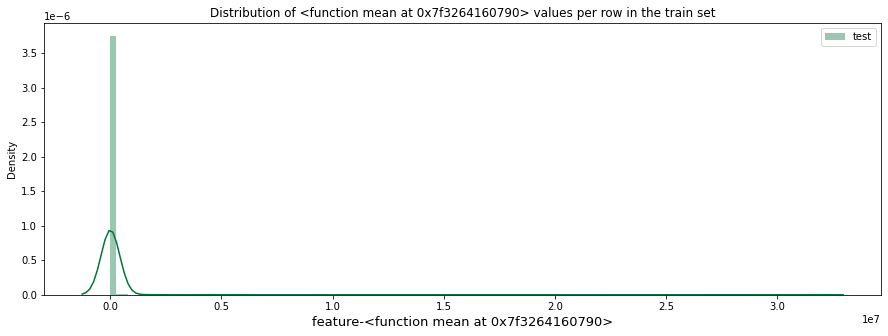

/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


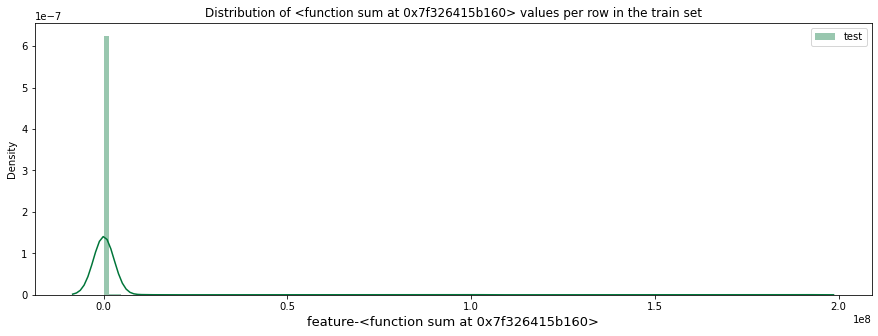

/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


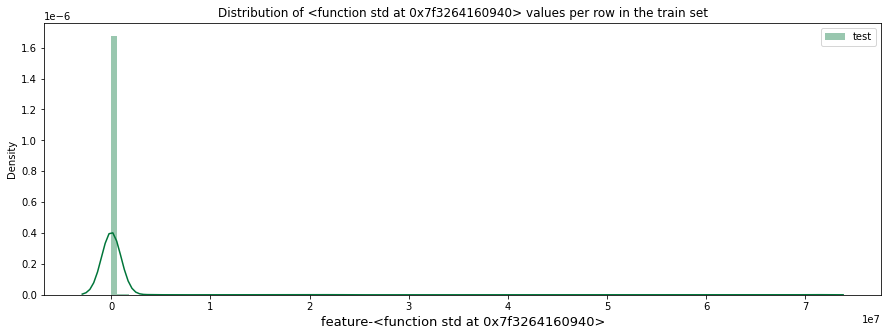

In [62]:
for func in [np.mean, np.sum, np.std]:
    plot_row_distribution(func, pd.concat([df_numerical_scal, df7['target']], axis=1))

Количественные данные имеют большое количество  пропущенных значений. На недефолтных наблюдениях разброс значений значительно шире чем на дефолтных, дефолтные значения лежат внутри недефолтных.

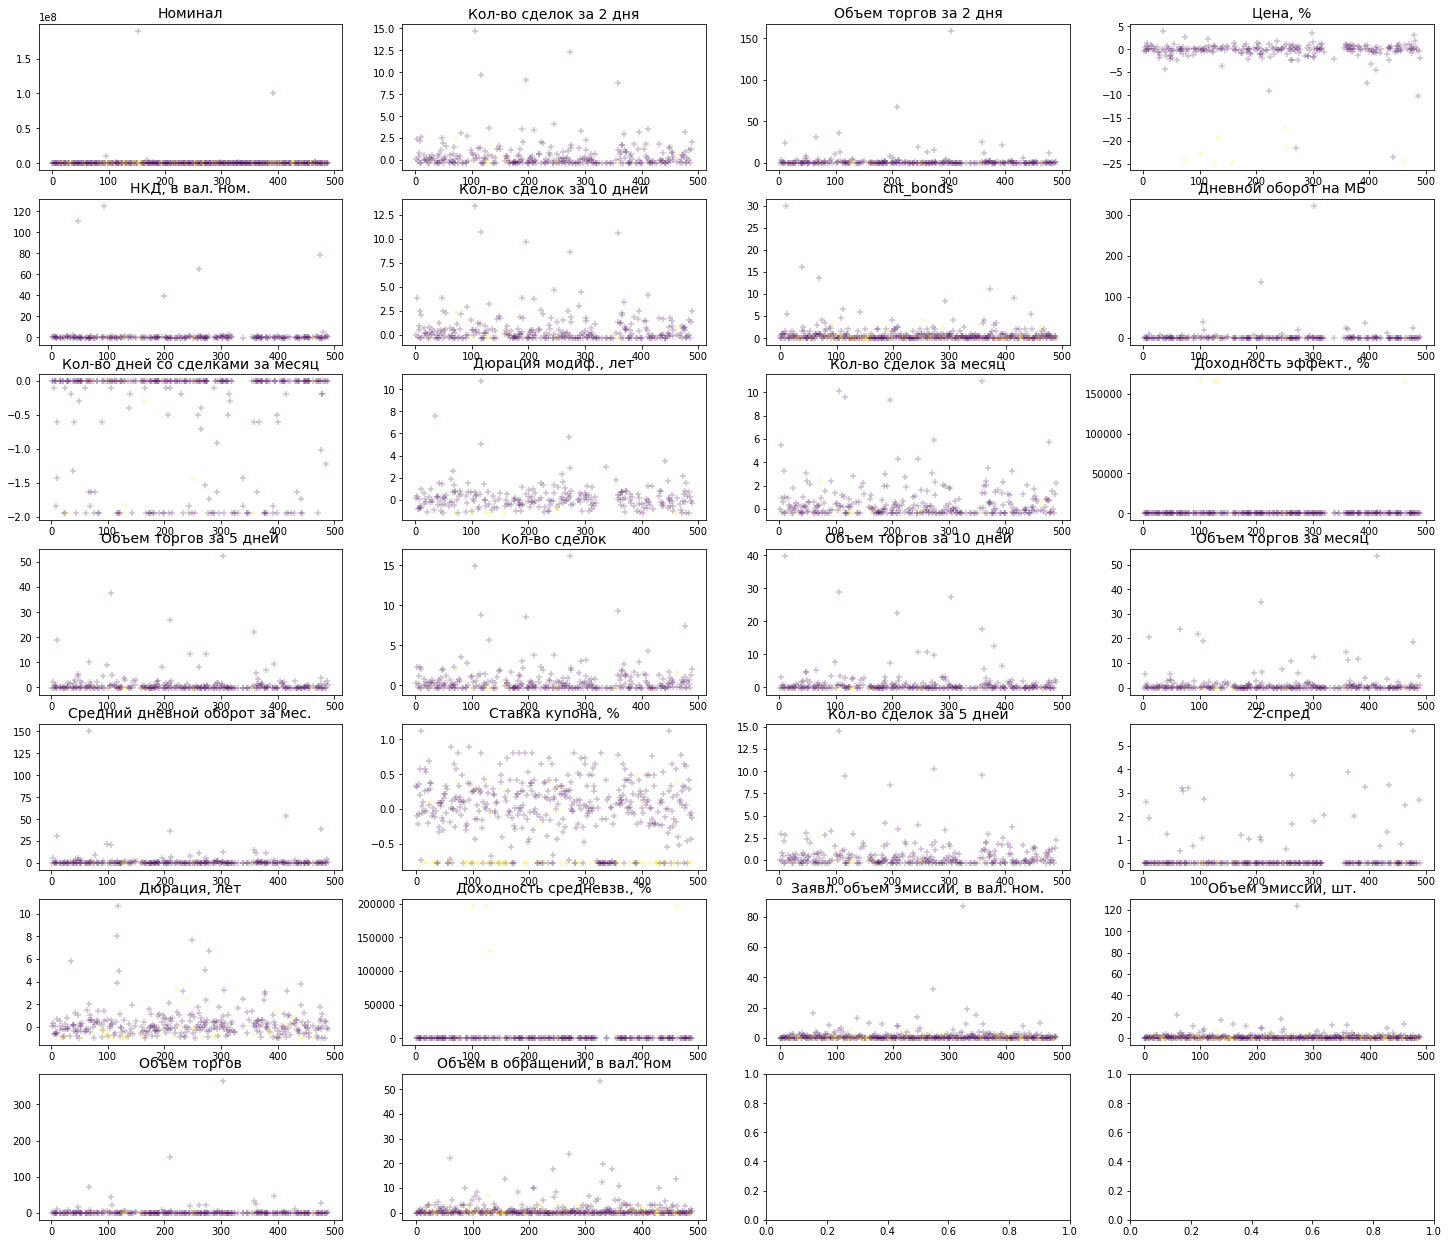

In [63]:
# распределение признаков в зависимости от значения целевой переменной
fig, axes = plt.subplots(7, 4, figsize=(25, 22))

for num, feature in enumerate(numerical_for_fit, start=1):
    plt.subplot(7, 4, num)
    plt.title(f"{feature}", size=14)
    plt.scatter(
        df_numerical_scal[feature].index,
        df_numerical_scal[feature],
        c=df7["target"],
        cmap="viridis",
        alpha=0.25,
        marker="+")

Распределение значений признаков по индексам неоднородное, распределение объектов целевого класса по признакам неоднородное.

# Исследование и заполнение пропущенных значений количественных признаков

<AxesSubplot:>

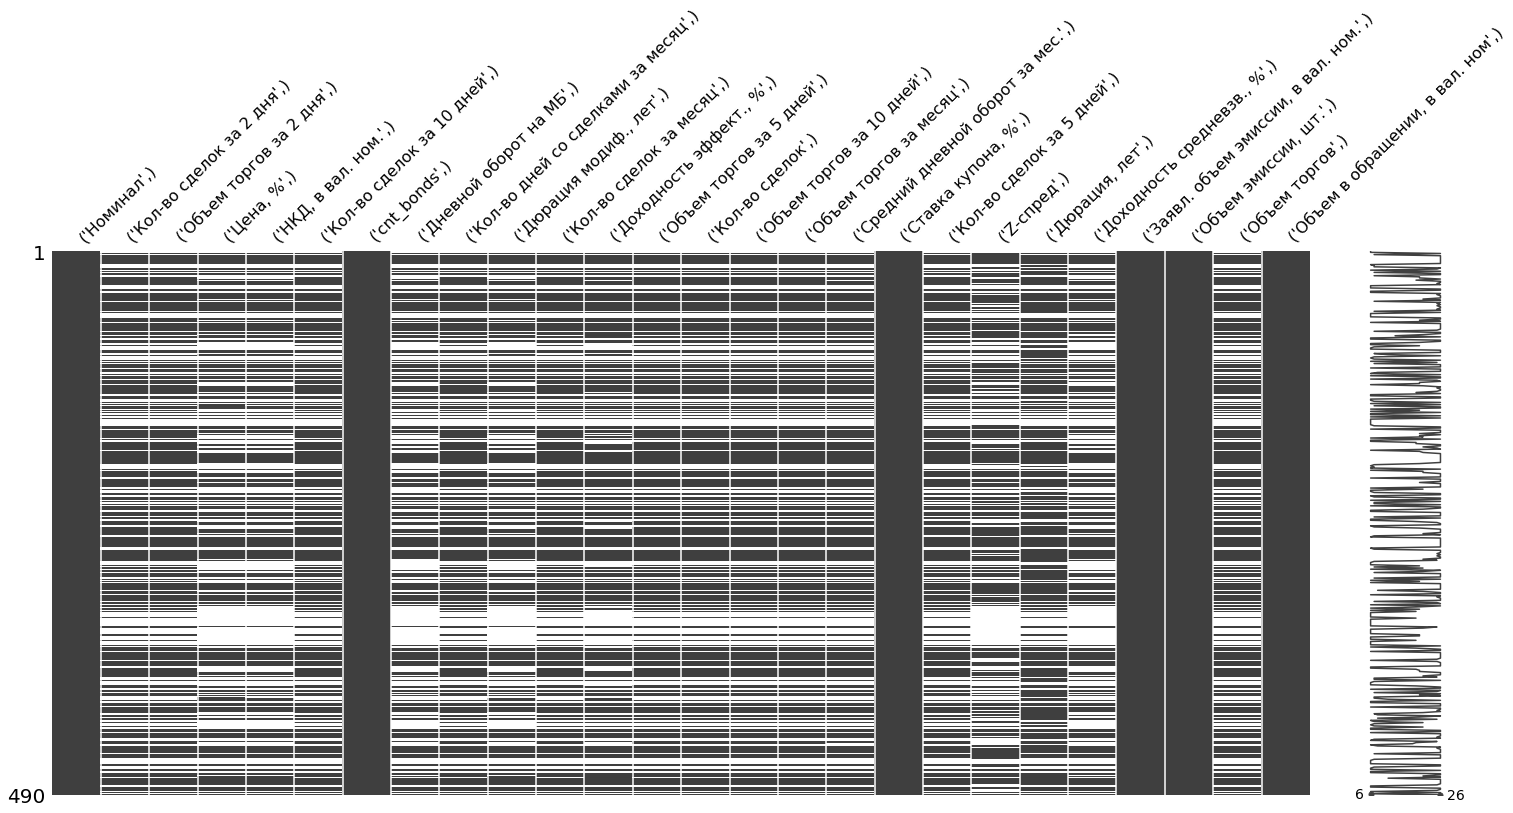

In [64]:
msno.matrix(df_numerical_scal)

<AxesSubplot:>

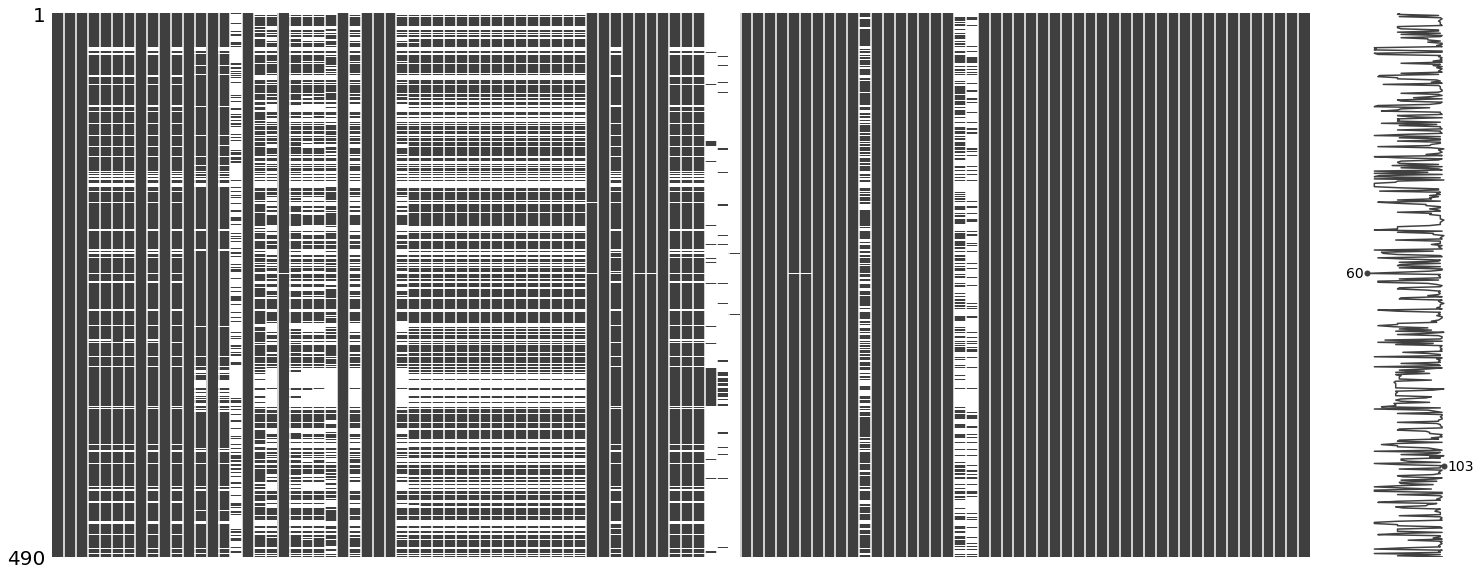

In [65]:
msno.matrix(df7)

Много строк с пропущенными значениями, но удалять их нельзя, т.к. в категориальных признаках значения имеются. Можно провести исследование по удалению этих строк в будущем. Но и исследование с оставленными этими строками тоже требуется.

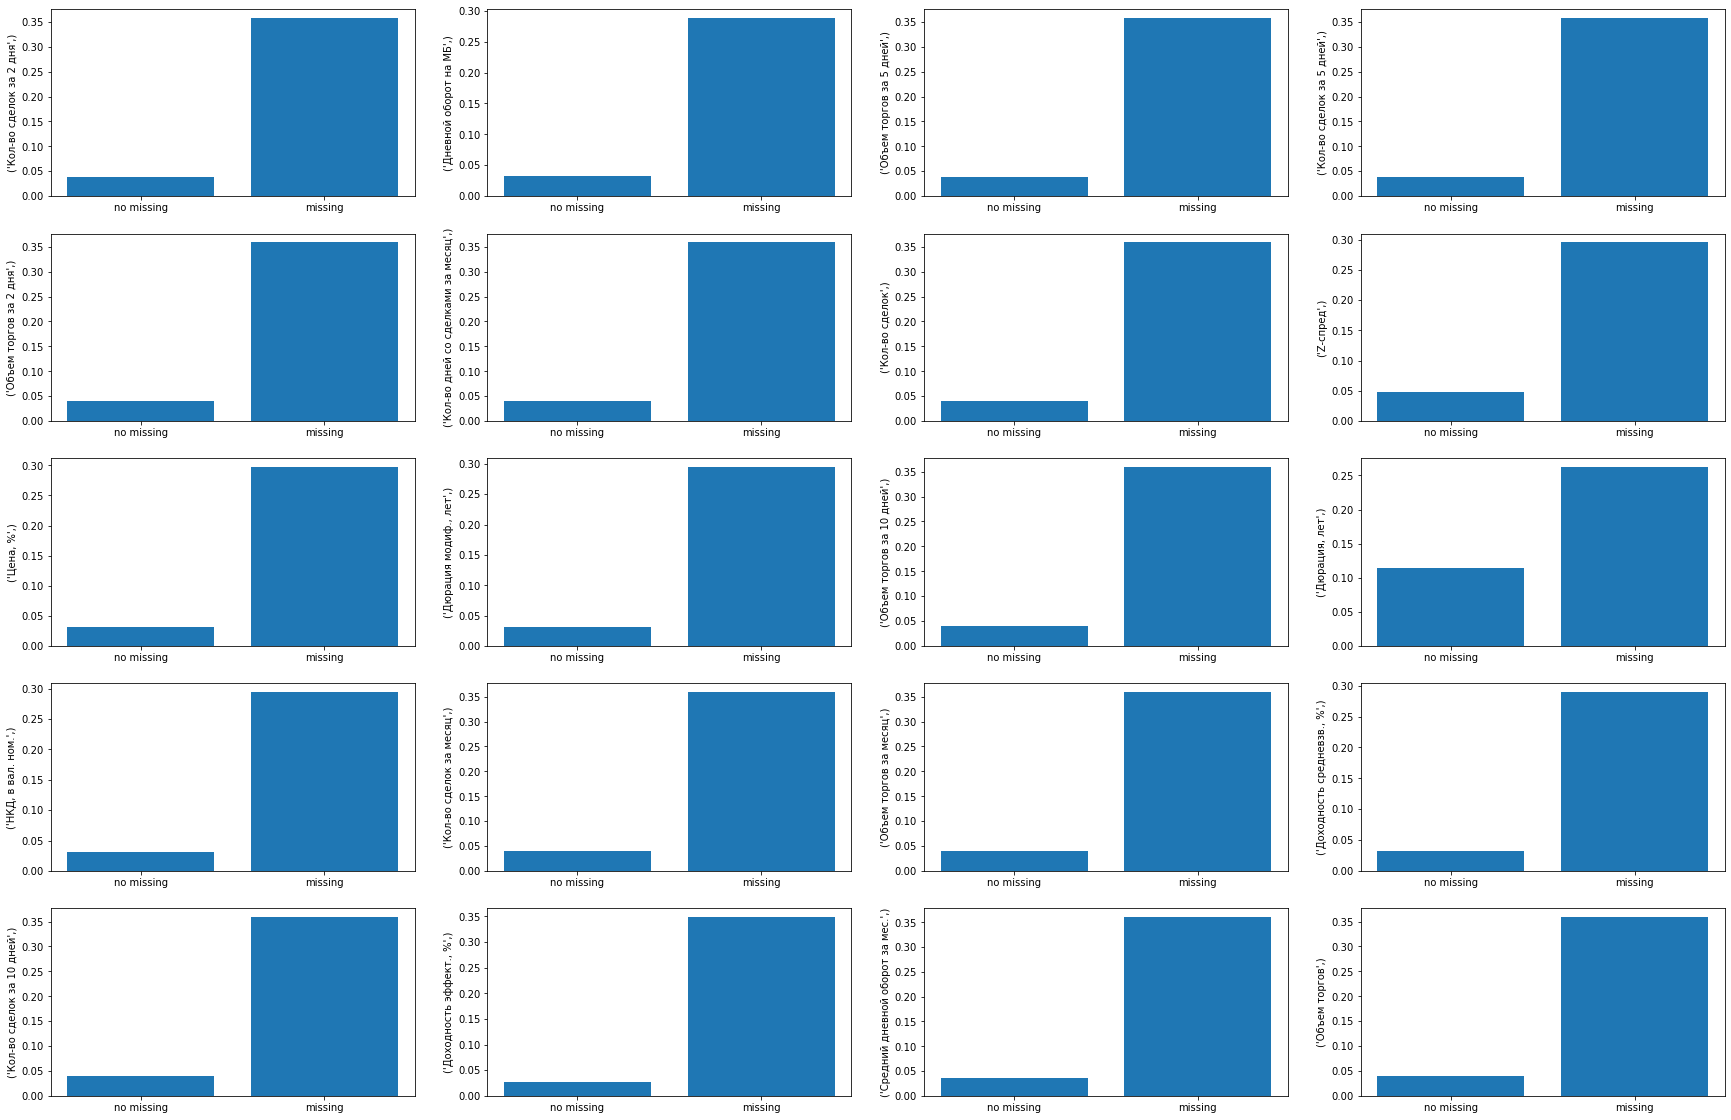

In [66]:
features_with_na = [
    feature for feature in df_numerical_scal.columns
    if df_numerical_scal[feature].isnull().sum() > 1]

fig, axes = plt.subplots(5, 4, figsize=(30, 20))
for num, feature in enumerate(features_with_na):
    data = pd.concat([df_numerical_scal, df7['target']], axis=1).copy()
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    statistics = data.groupby(feature)["target"].mean()
    axes[num%5, num//5].bar(statistics.index, statistics.values)
    axes[num%5, num//5].set_xticks([0, 1])
    axes[num%5, num//5].set_xticklabels(["no missing", "missing"])
    axes[num%5, num//5].set_ylabel(feature)

<AxesSubplot:xlabel='None', ylabel='None'>

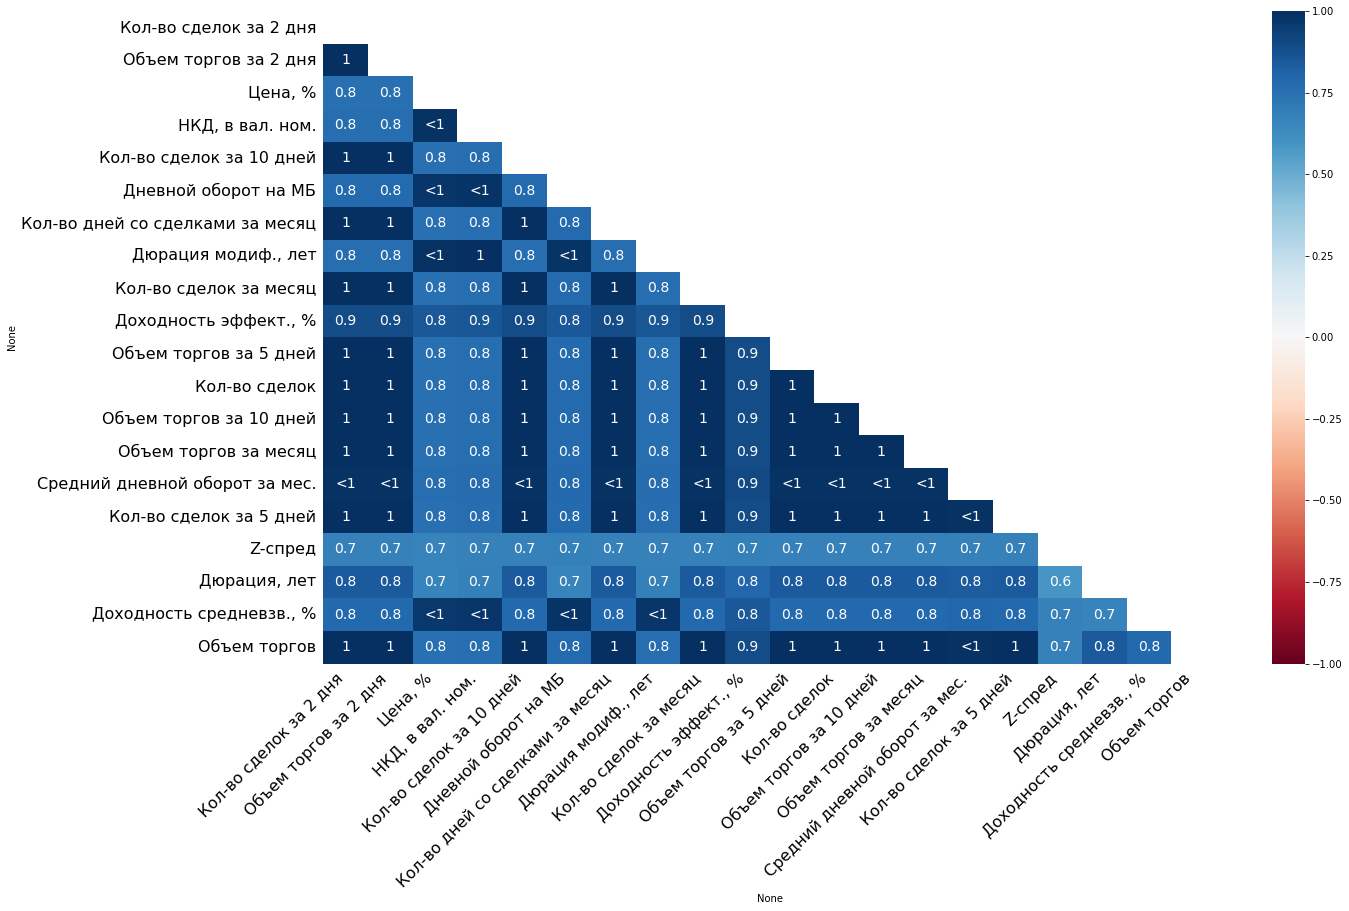

In [67]:
msno.heatmap(df_numerical_scal)

<AxesSubplot:>

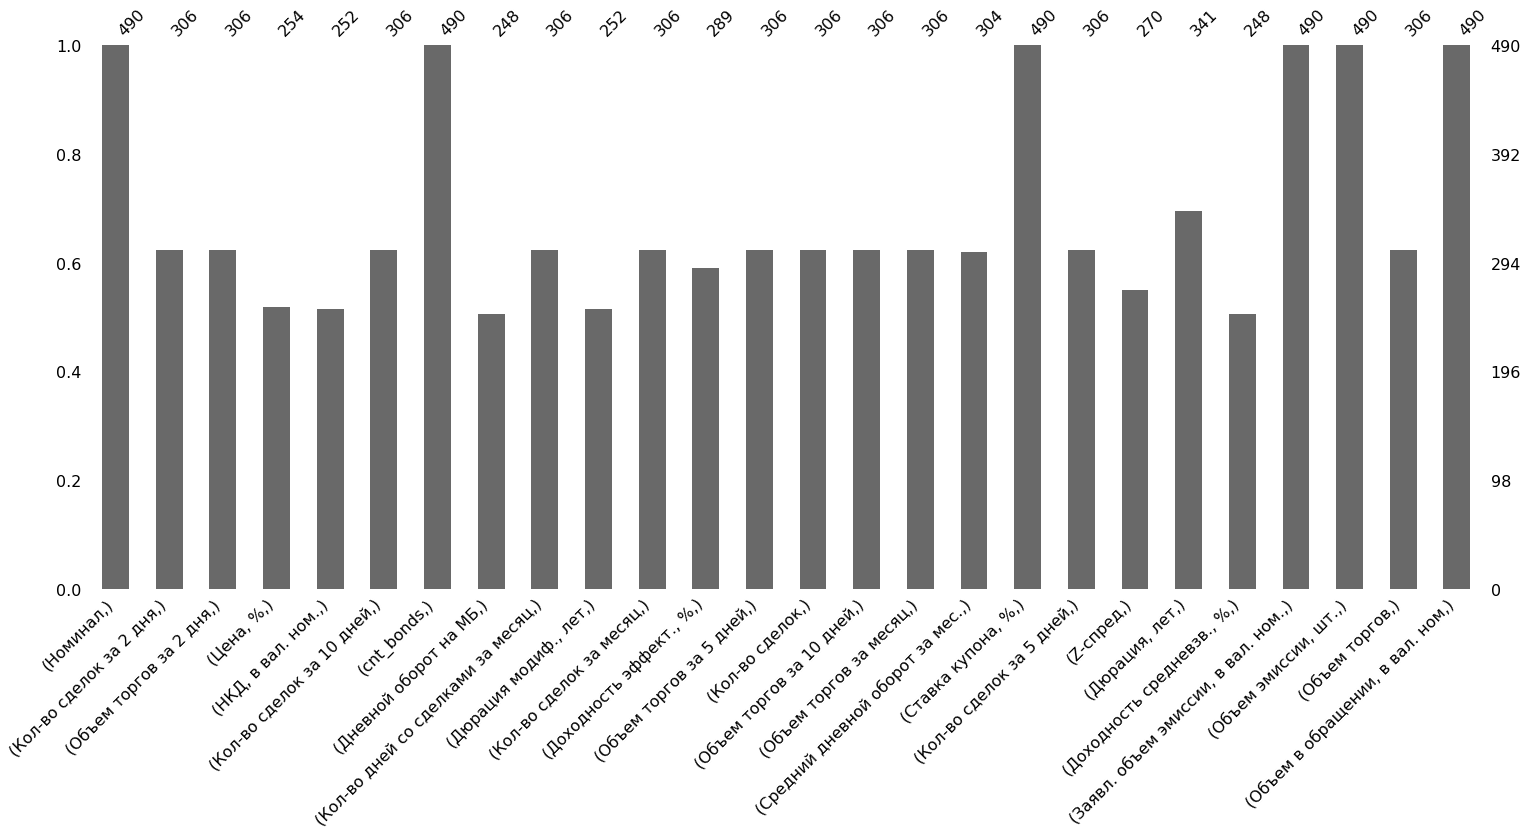

In [68]:
msno.bar(df_numerical_scal, labels=True)

Методами машинного обучения, из-за мизерного количества наблюдений с исследуемым событием, не получится. Пропущенных значений в колонках очень много, и статистики по ним не будут достаточно точными, особенно в наблюдениях с большим количеством пропущенных значений. Этому способствует и маленькое количество наблюдений. Но другого метода в нашем случае нету. Можно было бы еще брать статистику на интервалах значений признака, но этот метод тоже будет неточным из-за мизерного количества значений признака на интервалах. Из статистик, в связи с неравномерным распределением по признакам следует выбрать медиану. Заполню все пропуски медианами.

In [69]:
df_numerical_fillna = df_numerical_scal.fillna(df_numerical_scal.median())

# Понижение размерности количественных признаков.

Есть 2 метода - PCA и  TSNE. Но TSNE на таком количестве данных не обучится.

In [70]:
pca = PCA(n_components=3, svd_solver='full')
df_numerical_pca = pd.DataFrame(pca.fit_transform(df_numerical_fillna), 
                                columns=['pca_1', 'pca_2', 'pca_3'])
df_numerical_pca.T

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
pca_1,-538699.107328,-637699.107319,-637699.107329,-637699.107319,-637699.107325,-637699.107311,-637699.107324,-637699.107322,-637699.107334,-637699.107310,...,-637699.107281,-638599.107319,-638698.107319,-637699.107322,-637699.107396,-628699.107406,-638698.107319,-637699.107312,-637699.107319,-637699.107328
pca_2,-2018.483944,-2019.828483,-2019.074187,-2019.828483,-2019.439934,-2020.436289,-2019.454961,-2019.626356,-2018.744730,-2020.489652,...,-2022.651874,-2019.840709,-2019.842051,-2019.649341,-2014.199649,-2013.381833,-2019.842051,-2020.375940,-2019.828491,-2019.179157
pca_3,-15.569608,-15.580190,-15.712466,-15.580208,-15.697176,-15.518673,-15.691377,-15.696363,-15.722280,-14.225152,...,-15.014982,-15.580292,-15.580292,-15.676650,-13.822141,-15.907328,-15.580292,-15.657765,-15.580201,-15.659489


# Исследование категориальных признаков

In [71]:
df_spy_list = df7[spy_list]
df_spy_list.T

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
Ломбардный список БР,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0
Кол-во дней со сделками за 2 дня,NaN,NaN,2.0,NaN,2.0,2.0,2.0,2.0,2.0,0.0,...,2.0,NaN,NaN,2.0,2.0,2.0,NaN,2.0,NaN,2.0
Кол-во дней со сделками за 5 дней,NaN,NaN,5.0,NaN,5.0,5.0,5.0,5.0,5.0,0.0,...,5.0,NaN,NaN,5.0,5.0,4.0,NaN,5.0,NaN,5.0
Кол-во дней со сделками за 10 дней,NaN,NaN,10.0,NaN,10.0,10.0,10.0,10.0,10.0,1.0,...,10.0,NaN,NaN,10.0,10.0,5.0,NaN,10.0,NaN,10.0
Кол-во купонов в год,2.0,2.0,4.0,1.0,4.0,2.0,4.0,4.0,4.0,4.0,...,2.0,2.0,NaN,4.0,12.0,12.0,NaN,2.0,2.0,4.0
Субординированность,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Амортизируемость,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
Конвертация,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Закрытая подписка,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
target,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<AxesSubplot:>

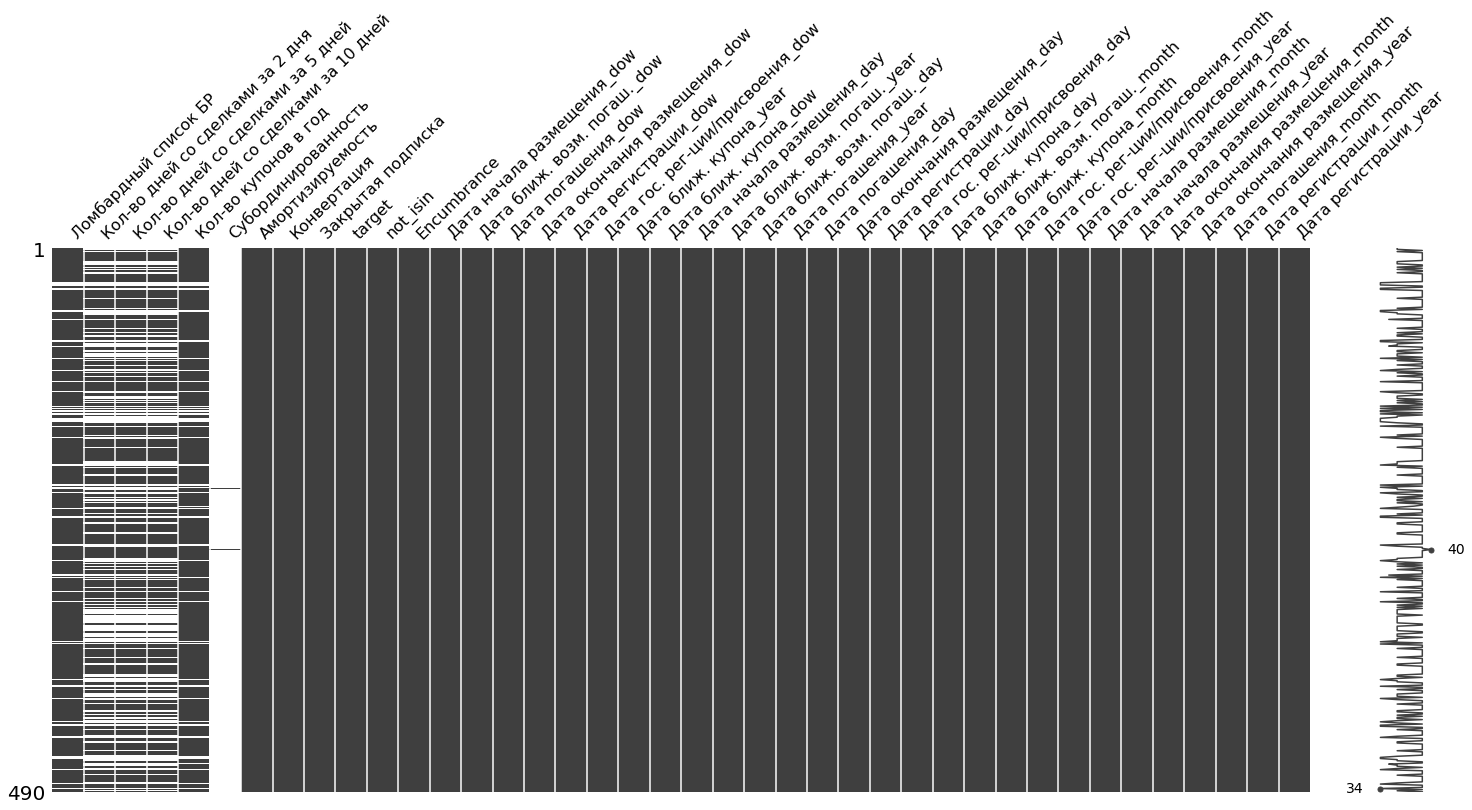

In [72]:
msno.matrix(df_spy_list)

In [73]:
df_spy_list.drop(['Субординированность'], axis=1, inplace=True)

/home/jb/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<AxesSubplot:>

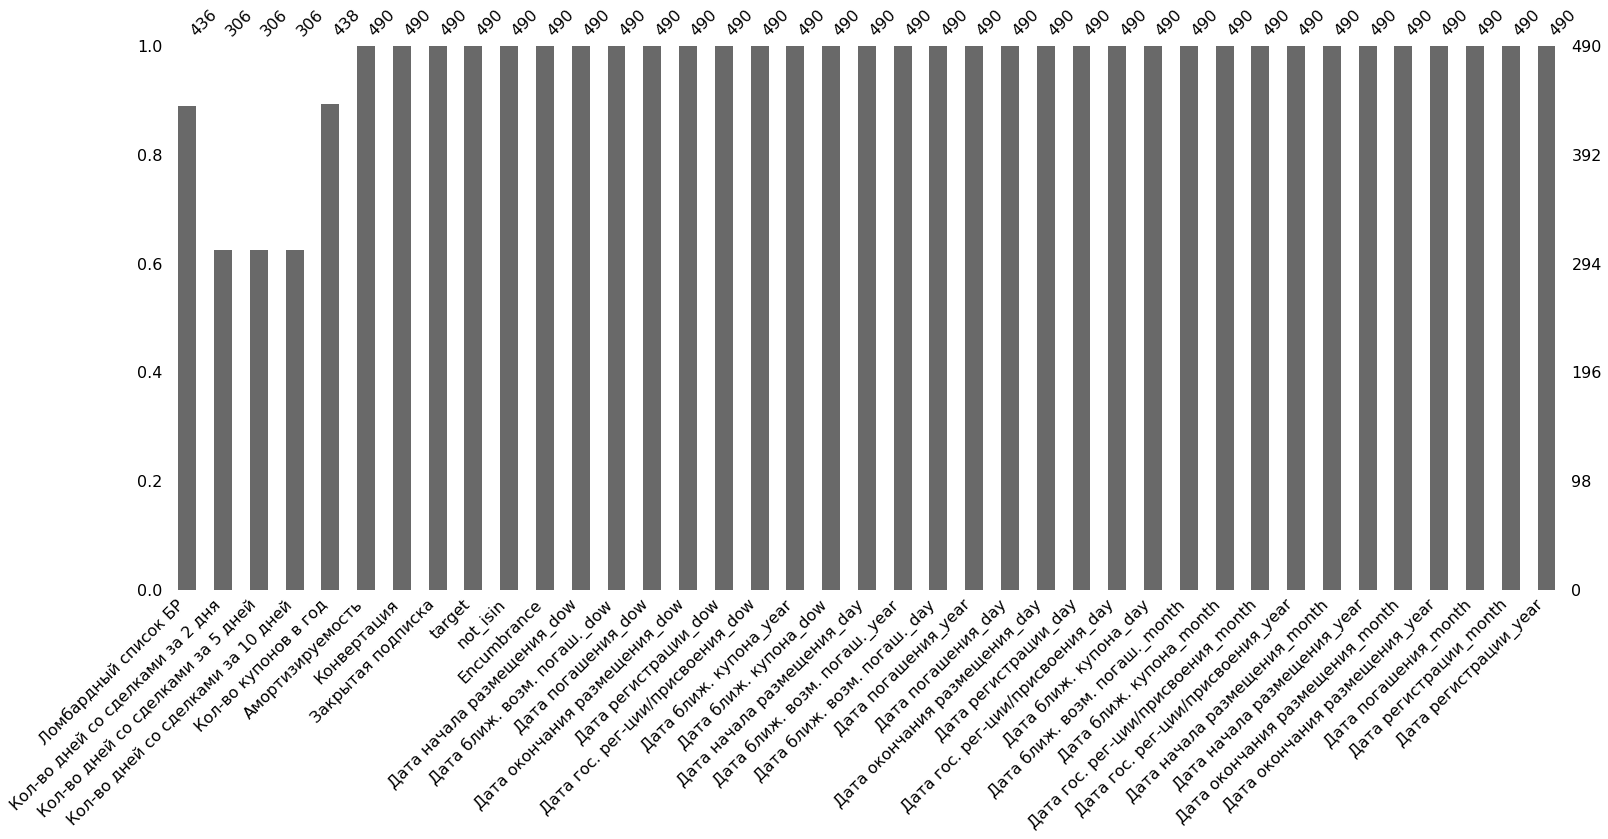

In [74]:
msno.bar(df_spy_list, labels=True)

Я уже показывал, что если заполнить пропущенные значения отдельной категорией, то сразу джек-пот :-). Методами машинного обучения заполнить не получится. Заполняю самой подходящей статистикой - модой.

In [75]:
for col in ['Ломбардный список БР', 'Кол-во дней со сделками за 2 дня', 'Кол-во дней со сделками за 5 дней',
    'Кол-во дней со сделками за 10 дней', 'Кол-во купонов в год']:
    df_spy_list[col]\
      .fillna(df_spy_list[col].mode()[0], inplace=True)
df_spy_list.T

/home/jb/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
Ломбардный список БР,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Кол-во дней со сделками за 2 дня,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
Кол-во дней со сделками за 5 дней,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,...,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0
Кол-во дней со сделками за 10 дней,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,...,10.0,10.0,10.0,10.0,10.0,5.0,10.0,10.0,10.0,10.0
Кол-во купонов в год,2.0,2.0,4.0,1.0,4.0,2.0,4.0,4.0,4.0,4.0,...,2.0,2.0,4.0,4.0,12.0,12.0,4.0,2.0,2.0,4.0
Амортизируемость,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
Конвертация,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Закрытая подписка,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
target,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
not_isin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [76]:
# Выделяю в датафрейм колонки с категориями
df_categorical = df7.select_dtypes(exclude = [np.number])
df_categorical.T

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
Эмитент,2М,4К,А Девелопмент,А7 Агро,АБЗ-1,АВТОБАН-Финанс,АВТОДОМ,АО им. Т.Г. Шевченко,АПРИ Флай Плэнинг,АС ФИНАНС,...,ЮГК,ЮЛКМ,ЮРАШ-АЛТЫН,Ювелит,ЮниМетрикс,ЮниСервис Капитал,ЯМАЛЫ-АЛТЫН,ЯТЭК,Ямал СПГ,реСтор
Дата начала размещения,2019-11-04 17:00:00,2021-09-01 17:00:00,2022-01-26 17:00:00,2019-08-14 17:00:00,2023-02-01 17:00:00,2021-09-13 17:00:00,2021-12-28 17:00:00,2022-07-27 17:00:00,2022-11-07 17:00:00,2018-12-17 17:00:00,...,2022-11-21 17:00:00,2018-12-12 17:00:00,2009-07-22 17:00:00,2022-12-26 17:00:00,2019-09-08 17:00:00,2021-03-03 17:00:00,2009-07-22 17:00:00,2021-04-11 17:00:00,2015-11-22 18:00:00,2021-06-16 17:00:00
Статус,В обращении,В обращении,В обращении,В обращении,В обращении,В обращении,В обращении,В обращении,В обращении,В обращении,...,В обращении,В обращении,Дефолт,В обращении,В обращении,В обращении,Дефолт,В обращении,В обращении,В обращении
"Состояние бумаги, eng.",Placed,Placed,Placed,Placed,Placed,Placed,Placed,Placed,Placed,Placed,...,Placed,Placed,NaN,Placed,Placed,Placed,NaN,Placed,Placed,Placed
Isin,RU000A100ZX3,RU000A103ML0,RU000A104FX7,RU000A100QH5,RU000A105SX7,RU000A103PC2,RU000A104CJ3,RU000A104ZU1,RU000A105DS9,RU000A0ZZYF7,...,RU000A105GS2,RU000A0ZZXQ6,NaN,RU000A105PK0,RU000A100T81,RU000A102TK9,NaN,RU000A102ZH2,RU000A0JVYR5,RU000A103935
Код НРД,RU000A100ZX3,RU000A103ML0,RU000A104FX7,RU000A100QH5,RU000A105SX7,RU000A103PC2,RU000A104CJ3,RU000A104ZU1,RU000A105DS9,RU000A0ZZYF7,...,RU000A105GS2,RU000A0ZZXQ6,NaN,RU000A105PK0,RU000A100T81,RU000A102TK9,NaN,RU000A102ZH2,RU000A0JVYR5,RU000A103935
Гос. рег. номер,4CDE-02-00503-R,4CDE-01-00041-L-001P,4-01-00627-R,4CDE-03-00411-R,4B02-03-01671-D-001P,4B02-03-82416-H-001P,4B02-01-12586-A-001P,4B02-04-34127-E-001P,4B02-01-12464-K-002P,4B02-01-00398-R-001P,...,4B02-01-33010-D-001P,4CDE-02-00401-R-001P,4-01-28025-R,4B02-01-87270-H-001P,4-01-00402-R,4-02-00534-R,4-01-28014-R,4B02-02-20510-F-001P,4-02-10428-A,4B02-01-00599-R-001P
"Номер гос. рег., НРД",4CDE-02-00503-R,4CDE-01-00041-L-001P,4-01-00627-R,4CDE-03-00411-R,4B02-03-01671-D-001P,4B02-03-82416-H-001P,4B02-01-12586-A-001P,4B02-04-34127-E-001P,4B02-01-12464-K-002P,4B02-01-00398-R-001P,...,4B02-01-33010-D-001P,4CDE-02-00401-R-001P,NaN,4B02-01-87270-H-001P,4-01-00402-R,4-02-00534-R,NaN,4B02-02-20510-F-001P,4-02-10428-A,4B02-01-00599-R-001P
Наименование,2М-КО-02,4К-KO1,А Девелопмент-01-об,А7 Агро-КО-03,АБЗ-1-001Р-03-боб,Автобан-Финанс-БО-ПО3,АВТОДОМ-001P-01,АО Т.Г.Шевченко-001Р-04,АПРИ ФлайПлэни-БО-002Р-01,АС ФИНАНС-001Р-01,...,ЮГК-001P-01,ЮЛКМ-КО-П02,ЮРАШ-АЛТЫН-1-об,Ювелит-001P-01,ЮниМетрикс-01-об,ЮниСервис Капитал-02К-об,ЯМАЛЫ-АЛТЫН-1-об,ЯТЭК-001Р-02,Ямал СПГ-2-об,реСтор-001Р-01
CFI,DBVUFB,DBFUFB,DBFUFB,DBVGFB,DBFUFB,DBVGFB,DBFUFB,DBVUFB,DBVUFB,DBVUFB,...,DBFUFB,DBVUFB,NaN,DBFUFB,DBFUFB,DBFSFB,NaN,DBFUFB,DBVXFB,DBFUFB


In [77]:
# Удаляю признаки

In [78]:
df_categorical['Страна риска'].value_counts()

RU    488
GE      1
BY      1
Name: Страна риска, dtype: int64

In [79]:
# Удаляю колонки
df_categorical = df_categorical.drop(columns=['Эмитент', 'Дата начала размещения', 'Isin', 'Код НРД', 'Гос. рег. номер',
            'Номер гос. рег., НРД', 'Наименование', 'Страна риска'])

In [80]:
def check_missings(df):
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result

In [81]:
check_missings(df_categorical)

Total NA-values = 2463


,Total,Percent,Types
Статус,0,0.000000,object
"Состояние бумаги, eng.",54,11.020408,object
CFI,53,10.816327,object
Страна заемщика,0,0.000000,object
Сектор заемщика,55,11.224490,object
Регион эмитента,0,0.000000,object
Сектор эмитента,56,11.428571,object
Эмитент: реестр МСП,362,73.877551,object
Срок обращения,1,0.204082,object
Тип купона,2,0.408163,object


In [82]:
df_categorical['Эмитент: реестр МСП'].value_counts()

Малое предприятие      66
Микропредприятие       38
Среднее предприятие    24
Name: Эмитент: реестр МСП, dtype: int64

In [83]:
df_categorical['Тип бумаги (МСП, Корп., Гос.)'].value_counts()

M    314
C    166
G     10
Name: Тип бумаги (МСП, Корп., Гос.), dtype: int64

Заполнено только 25% малых предприятий в признаке "Эмитент: реестр МСП". Заполнить остальное модой - слишком большая будет ошибка в данных. 

Далее проверяю версии: делаю фильтрацию по датасету.

In [84]:
df_categorical[['Тип бумаги (МСП, Корп., Гос.)', 'Эмитент: реестр МСП']].\
   loc[(df_categorical['Тип бумаги (МСП, Корп., Гос.)']=='M') & \
   (df_categorical['Эмитент: реестр МСП'].isna()==0)][['Эмитент: реестр МСП']].value_counts()

Эмитент: реестр МСП
Малое предприятие      66
Микропредприятие       37
Среднее предприятие    23
dtype: int64

In [85]:
df_categorical['Класс эмитента по выручке'].value_counts()

Крупный    129
Малый       92
Средний     79
Микро       43
Name: Класс эмитента по выручке, dtype: int64

In [86]:
df_categorical[['Класс эмитента по выручке', 'Эмитент: реестр МСП']].\
   loc[(df_categorical['Класс эмитента по выручке']=='Малый') & \
   (df_categorical['Эмитент: реестр МСП'].isna()==0)][['Эмитент: реестр МСП']].value_counts()

Эмитент: реестр МСП
Малое предприятие      45
Микропредприятие       10
Среднее предприятие     6
dtype: int64

In [87]:
df_categorical[['Класс эмитента по выручке', 'Эмитент: реестр МСП']].\
   loc[(df_categorical['Класс эмитента по выручке']=='Микро') & \
   (df_categorical['Эмитент: реестр МСП'].isna()==0)][['Эмитент: реестр МСП']].value_counts()

Эмитент: реестр МСП
Микропредприятие       10
Малое предприятие       8
Среднее предприятие     3
dtype: int64

In [88]:
df_categorical[['Класс эмитента по выручке', 'Тип бумаги (МСП, Корп., Гос.)']].\
   loc[(df_categorical['Класс эмитента по выручке']=='Крупный') & \
   (df_categorical['Класс эмитента по выручке'].isna()==0)][['Тип бумаги (МСП, Корп., Гос.)']].value_counts()

Тип бумаги (МСП, Корп., Гос.)
C                                115
M                                 14
dtype: int64

In [89]:
df_categorical[['Класс эмитента по выручке', 'Тип бумаги (МСП, Корп., Гос.)']].\
   loc[(df_categorical['Класс эмитента по выручке']=='Малый') & \
    (df_categorical['Класс эмитента по выручке'].isna()==0)][['Тип бумаги (МСП, Корп., Гос.)']].value_counts()

Тип бумаги (МСП, Корп., Гос.)
M                                89
C                                 3
dtype: int64

'Класс эмитента по выручке', 'Эмитент: реестр МСП' и 'Тип бумаги (МСП, Корп., Гос.)' раскоррелированы друг с другом. Похоже это разные источники. Поэтому оставляю самый полный источник 'Тип бумаги (МСП, Корп., Гос.)'. В нем нет ни одного пропуска, и надеюсь, что он и ведется более аккуратно в плане точности.

'Вид залога' можно предположить что пропущены значения где залога не было. "Структурированность" тоже можно попробовать предположить что структура не известна. Добавлю по новому значению.

In [90]:
df_categorical.loc[df_categorical['Вид залога'].isna()==1, 'Вид залога'] = 'NAN'

In [91]:
df_categorical.loc[df_categorical['Структурированность'].isna()==1, 'Структурированность'] = 'NAN'

In [92]:
df_categorical.loc[df_categorical['Рейтинг эмиссии'].isna()==0][:50]

,Статус,"Состояние бумаги, eng.",CFI,Страна заемщика,Сектор заемщика,Регион эмитента,Сектор эмитента,Эмитент: реестр МСП,Срок обращения,Тип купона,...,Гос. гарантия,Индексируемость номинала,Вид обеспечения,Старшинство секьюритизации,"Тип бумаги (МСП, Корп., Гос.)",Сектор повышенного инвест. риска,Сектор роста,Класс эмитента по выручке,Рейтинг агрег,Рейтинг эмиссии
4,В обращении,Placed,DBFUFB,RU,Строительство,г.Санкт-Петербург,Строительство,NaN,Краткосрочные,Постоянный,...,НЕТ,НЕТ,Оферта,416,C,НЕТ,НЕТ,NaN,BBB(RU),BBB(RU)
5,В обращении,Placed,DBVGFB,RU,"Фин.сервис - УК, НПФ, ПИФ",г.Москва,"Фин.сервис - УК, НПФ, ПИФ",NaN,Среднесрочные,Переменный,...,НЕТ,НЕТ,Оферта+Поручительство,416,C,НЕТ,НЕТ,Крупный,ruA,ruA
11,В обращении,Placed,DBFUFB,RU,Строительство,г.Москва,Строительство,NaN,Краткосрочные,Постоянный,...,НЕТ,НЕТ,Необеспеченные,416,C,НЕТ,НЕТ,Крупный,ruAA+,ruAA+
30,В обращении,Placed,DBFUFB,RU,Нефтегазовый,г.Москва,Нефтегазовый,Среднее предприятие,Краткосрочные,Постоянный,...,НЕТ,НЕТ,Оферта,416,M,ДА,НЕТ,NaN,'ruBBB,'ruBBB
34,В обращении,Placed,DBFUFB,RU,Нефтегазовый,г.Москва,Нефтегазовый,NaN,Среднесрочные,Постоянный,...,НЕТ,НЕТ,Оферта,416,C,НЕТ,НЕТ,Крупный,ruAA,ruAA
40,В обращении,Placed,DBFUFB,RU,"Химпром, минудобрения",Республика Башкортостан,"Химпром, минудобрения",NaN,Среднесрочные,Постоянный,...,НЕТ,НЕТ,Необеспеченные,416,C,НЕТ,НЕТ,Крупный,ruA+,ruA+
41,В обращении,Placed,DBFXFR,RU,Государственные,Белгородская область,Государственные,NaN,Среднесрочные,Постоянный,...,НЕТ,НЕТ,Необеспеченные,416,G,НЕТ,НЕТ,NaN,AA-(RU),AA-(RU)
42,В обращении,Placed,DBFUFB,RU,Пищевая промышленность и с/х,Московская область,Пищевая промышленность и с/х,NaN,Среднесрочные,Постоянный,...,НЕТ,НЕТ,Необеспеченные,416,C,НЕТ,НЕТ,Крупный,ruA+,ruA+
43,В обращении,Placed,DBFUFB,RU,Недвижимость,г.Москва,Недвижимость,NaN,Среднесрочные,Постоянный,...,НЕТ,НЕТ,Необеспеченные,416,C,НЕТ,НЕТ,Крупный,'ruBBB+,'ruBBB+
44,В обращении,Placed,DBVUFB,RU,Фармацевтика,г.Москва,Фармацевтика,NaN,Долгосрочные,Переменный,...,НЕТ,НЕТ,Необеспеченные,416,C,НЕТ,НЕТ,Крупный,ruA,ruA


Оба рейтинга друг друга дублируют, за исключением того, что немного различается само обозначение, но в "Рейтинг эмиссии" пропусков больше. Удаляю. А наны замещаю новой категорией.

In [93]:
df_categorical.loc[df_categorical['Рейтинг агрег'].isna()==1, 'Рейтинг агрег'] = 'NAN'

In [94]:
df_categorical.drop(columns=['Рейтинг эмиссии', 'Класс эмитента по выручке',
                             'Эмитент: реестр МСП'], inplace=True)

In [95]:
check_missings(df_categorical)

Total NA-values = 387


,Total,Percent,Types
Статус,0,0.000000,object
"Состояние бумаги, eng.",54,11.020408,object
CFI,53,10.816327,object
Страна заемщика,0,0.000000,object
Сектор заемщика,55,11.224490,object
Регион эмитента,0,0.000000,object
Сектор эмитента,56,11.428571,object
Срок обращения,1,0.204082,object
Тип купона,2,0.408163,object
Валюта номинала,0,0.000000,object


OK! Остальные пропуски заполняю модой.

In [96]:
for col in ['Состояние бумаги, eng.', 'CFI', 'Сектор заемщика', 'Сектор эмитента', 'Срок обращения',
           'Тип купона', 'Тип облигации', 'Форма выпуска, eng', 'Способ размещения', 'Тип по классиф. БР',
           'Вид обеспечения', 'Старшинство секьюритизации', 'Вид облигации']:
    df_categorical[col]\
      .fillna(df_categorical[col].mode()[0], inplace=True)
df_categorical.isna().sum().sum()

0

Меняю тип данных:

In [97]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Статус                            490 non-null    object
 1   Состояние бумаги, eng.            490 non-null    object
 2   CFI                               490 non-null    object
 3   Страна заемщика                   490 non-null    object
 4   Сектор заемщика                   490 non-null    object
 5   Регион эмитента                   490 non-null    object
 6   Сектор эмитента                   490 non-null    object
 7   Срок обращения                    490 non-null    object
 8   Тип купона                        490 non-null    object
 9   Валюта номинала                   490 non-null    object
 10  Тип облигации                     490 non-null    object
 11  Вид облигации                     490 non-null    object
 12  Для неквал. инвесторов

In [98]:
# для красоты )
df_spy_list = df_spy_list.astype('int16')

In [99]:
df_spy_list = df_spy_list.astype('str')

In [100]:
# объединяю эти датасеты
df_categorical_full = pd.concat([df_spy_list, df_categorical], axis=1)

In [101]:
df_categorical_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 65 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Ломбардный список БР                490 non-null    object
 1   Кол-во дней со сделками за 2 дня    490 non-null    object
 2   Кол-во дней со сделками за 5 дней   490 non-null    object
 3   Кол-во дней со сделками за 10 дней  490 non-null    object
 4   Кол-во купонов в год                490 non-null    object
 5   Амортизируемость                    490 non-null    object
 6   Конвертация                         490 non-null    object
 7   Закрытая подписка                   490 non-null    object
 8   target                              490 non-null    object
 9   not_isin                            490 non-null    object
 10  Encumbrance                         490 non-null    object
 11  Дата начала размещения_dow          490 non-null    object

In [102]:
# Собираю весь датасет
df_all = pd.concat([df_categorical_full, df_numerical_pca, df7['target']], axis=1)

In [103]:
df_all.to_csv("df_after_eda.csv", index=False)

Последующий анализ признаков будет уже первым этапом предсказания. Поэтому буду проводить его в ноутбуке Prediction.

In [104]:
!pip freeze eda_requirements.txt

absl-py==1.2.0
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client @ file:///tmp/build/80754af9/anaconda-client_1635330891925/work
anaconda-navigator==2.3.2
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1626085644852/work
annoy==1.17.0
anyio==3.6.1
apache-beam==2.41.0
appdirs==1.4.4
APScheduler==3.6.3
argh==0.26.2
argon2-cffi @ file:///tmp/build/80754af9/argon2-cffi_1613037097816/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///tmp/build/80754af9/astroid_1628063142195/work
astropy @ file:///tmp/build/80754af9/astropy_1629829212064/work
astunparse==1.6.3
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1620827162558/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1596578164842/work
auxiliary==1.0.1
avro-python3==1.10.2
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall @ file:///home